# Clustering

$\color{red}{\text{Cluster analysis}}$ is a widely used technique in $\color{red}{\text{unsupervised learning}}$, where the objective is to discover meaningful patterns and structures within a given dataset.

The main goal of cluster analysis is to partition the data into $\color{red}{\text{homogeneous subgroups}}$ or clusters. We can think of clusters as $\color{red}{\text{high-density regions}}$ within a multidimensional space.

A cluster represents a collection of items (objects, points) that are $\color{red}{\text{similar or closely related}}$ to each other, while being distinct from items in other clusters.

Clustering serves as a valuable statistical tool for organizing large amounts of $\color{red}{\text{multivariate data}}$ into cohesive and meaningful groups.

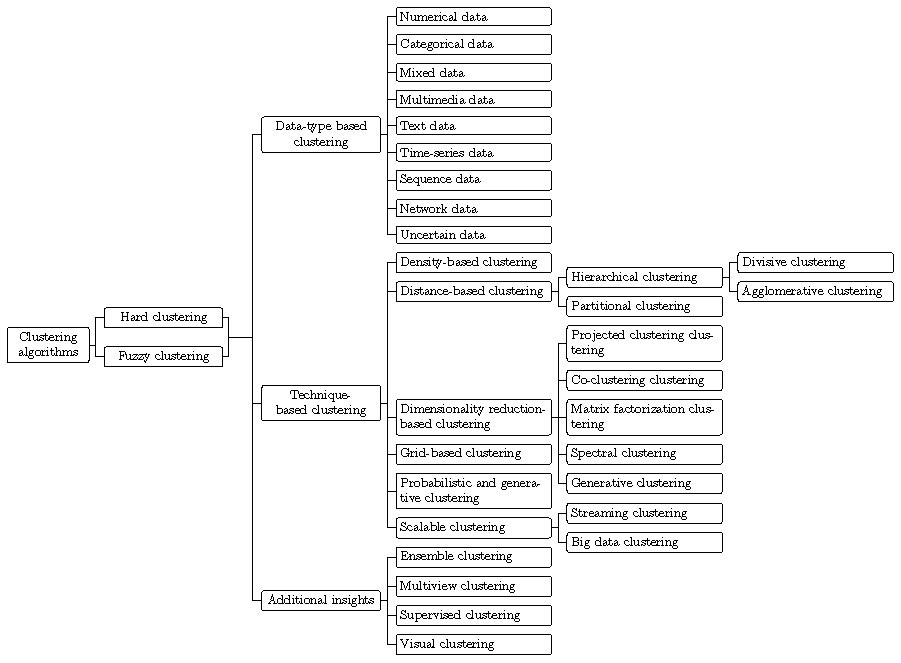

## Nonhierarchical/Flat/Partitioning clustering
- Split data items into a predetermined number $K$ of clusters, where  there is no hierarchical relationship between any two clusters. 
- Items within each cluster are similar to each other,  whereas items from different clusters are quite dissimilar.
- Do not need to store large proximity matrices –> computationally more  efficient than are hierarchical methods.

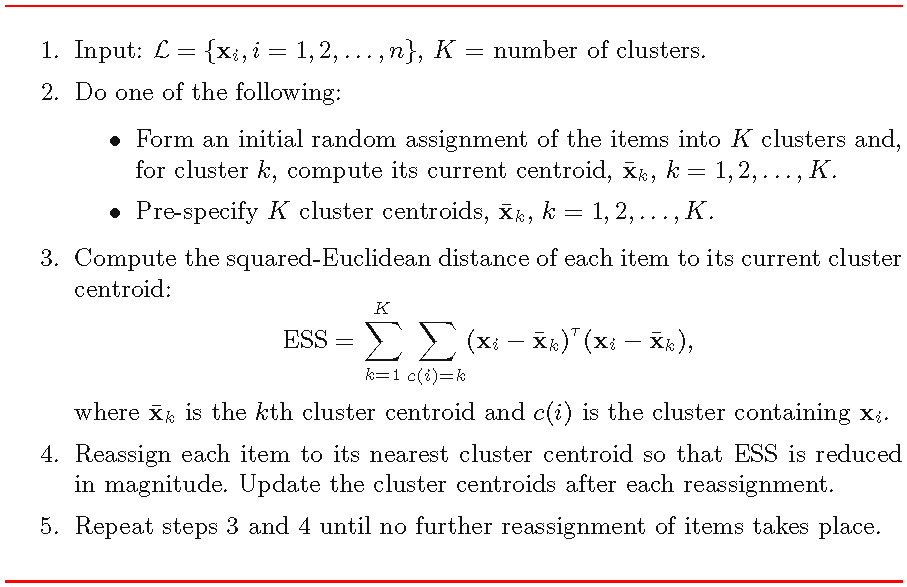

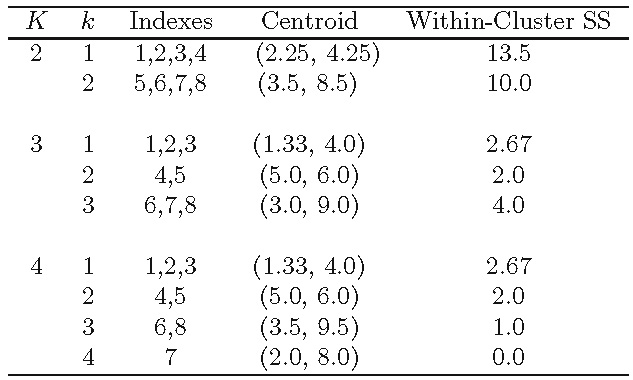

## Hierarchical Clustering
- $\color{red}{\text{Agglomerative clustering (bottom-up)}}$: start with each  item being its own cluster; then, clusters are successively merged, until only a single cluster remains.

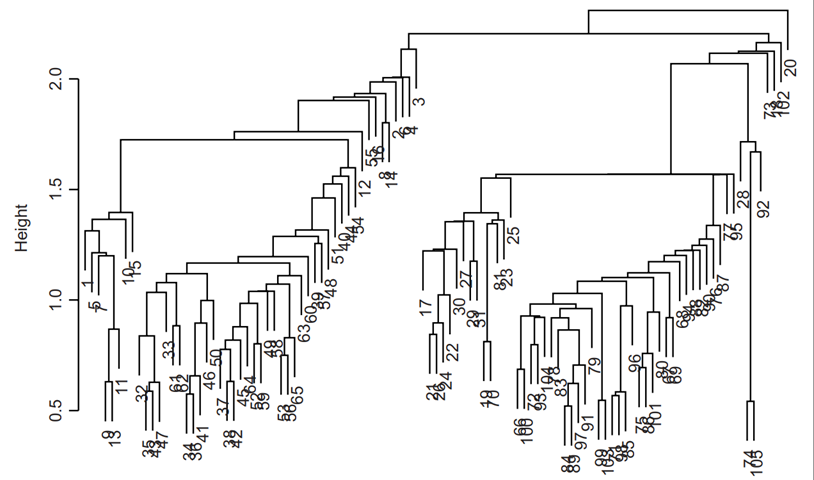

- $\color{red}{\text{Divisive clustering (top-down)}}$: start with all items as  members of a single cluster; then, that cluster is split  into two separate clusters, and so on for every successive cluster, until each item is its own cluster.

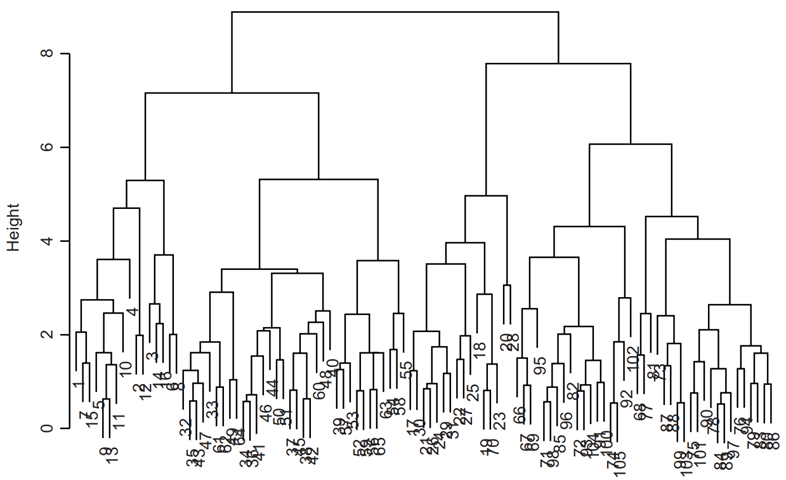

$\color{red}{\text{Agglomerative clustering (bottom-up)}}$ pseudo-code:

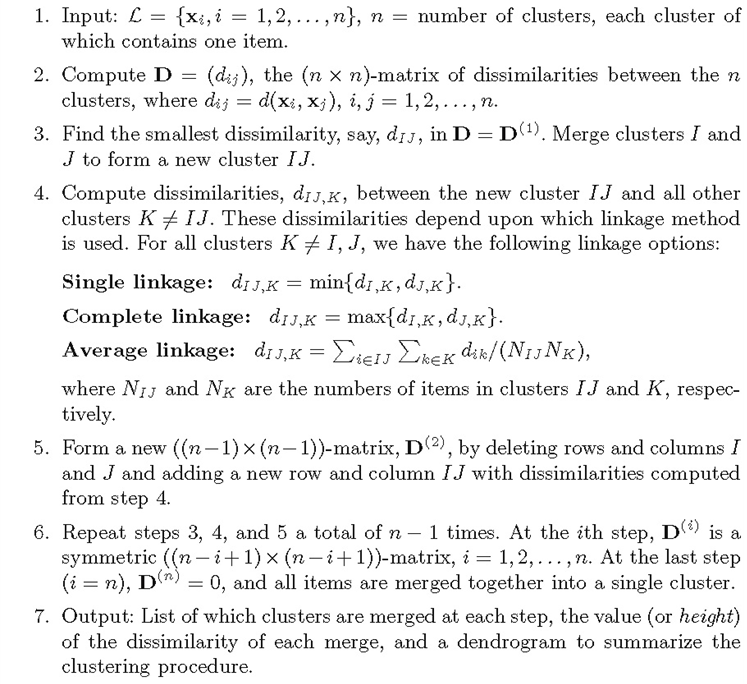

Example:

![Alt text](image.png)

![Alt text](image-1.png)

![Alt text](image-2.png)

![Alt text](image-3.png)

## HDBSCAN
- HDBSCAN is a clustering algorithm developed by [Campello, Moulavi, and Sander](http://link.springer.com/chapter/10.1007%2F978-3-642-37456-2_14). It extends DBSCAN by converting it into a hierarchical clustering algorithm, and then using a technique to extract a flat clustering based in the stability of clusters.

- what actually happened? We can break it out into a series of steps
1. Transform the space according to the density/sparsity.
2. Build the minimum spanning tree of the distance weighted graph.
3. Construct a cluster hierarchy of connected components.
4. Condense the cluster hierarchy based on minimum cluster size.
5. Extract the stable clusters from the condensed tree.

#### 1. Transform the space

To enhance the robustness of clustering algorithms against noise, first estimate density using the distance to the k-th nearest neighbor. 
This allows identify "sea" points with lower density by using the mutual reachability distance metric, defined as:

$d_{\mathrm{mreach-}k}(a,b)$ = $\max \{\mathrm{core}_k(a), \mathrm{core}_k(b), d(a,b) \}$

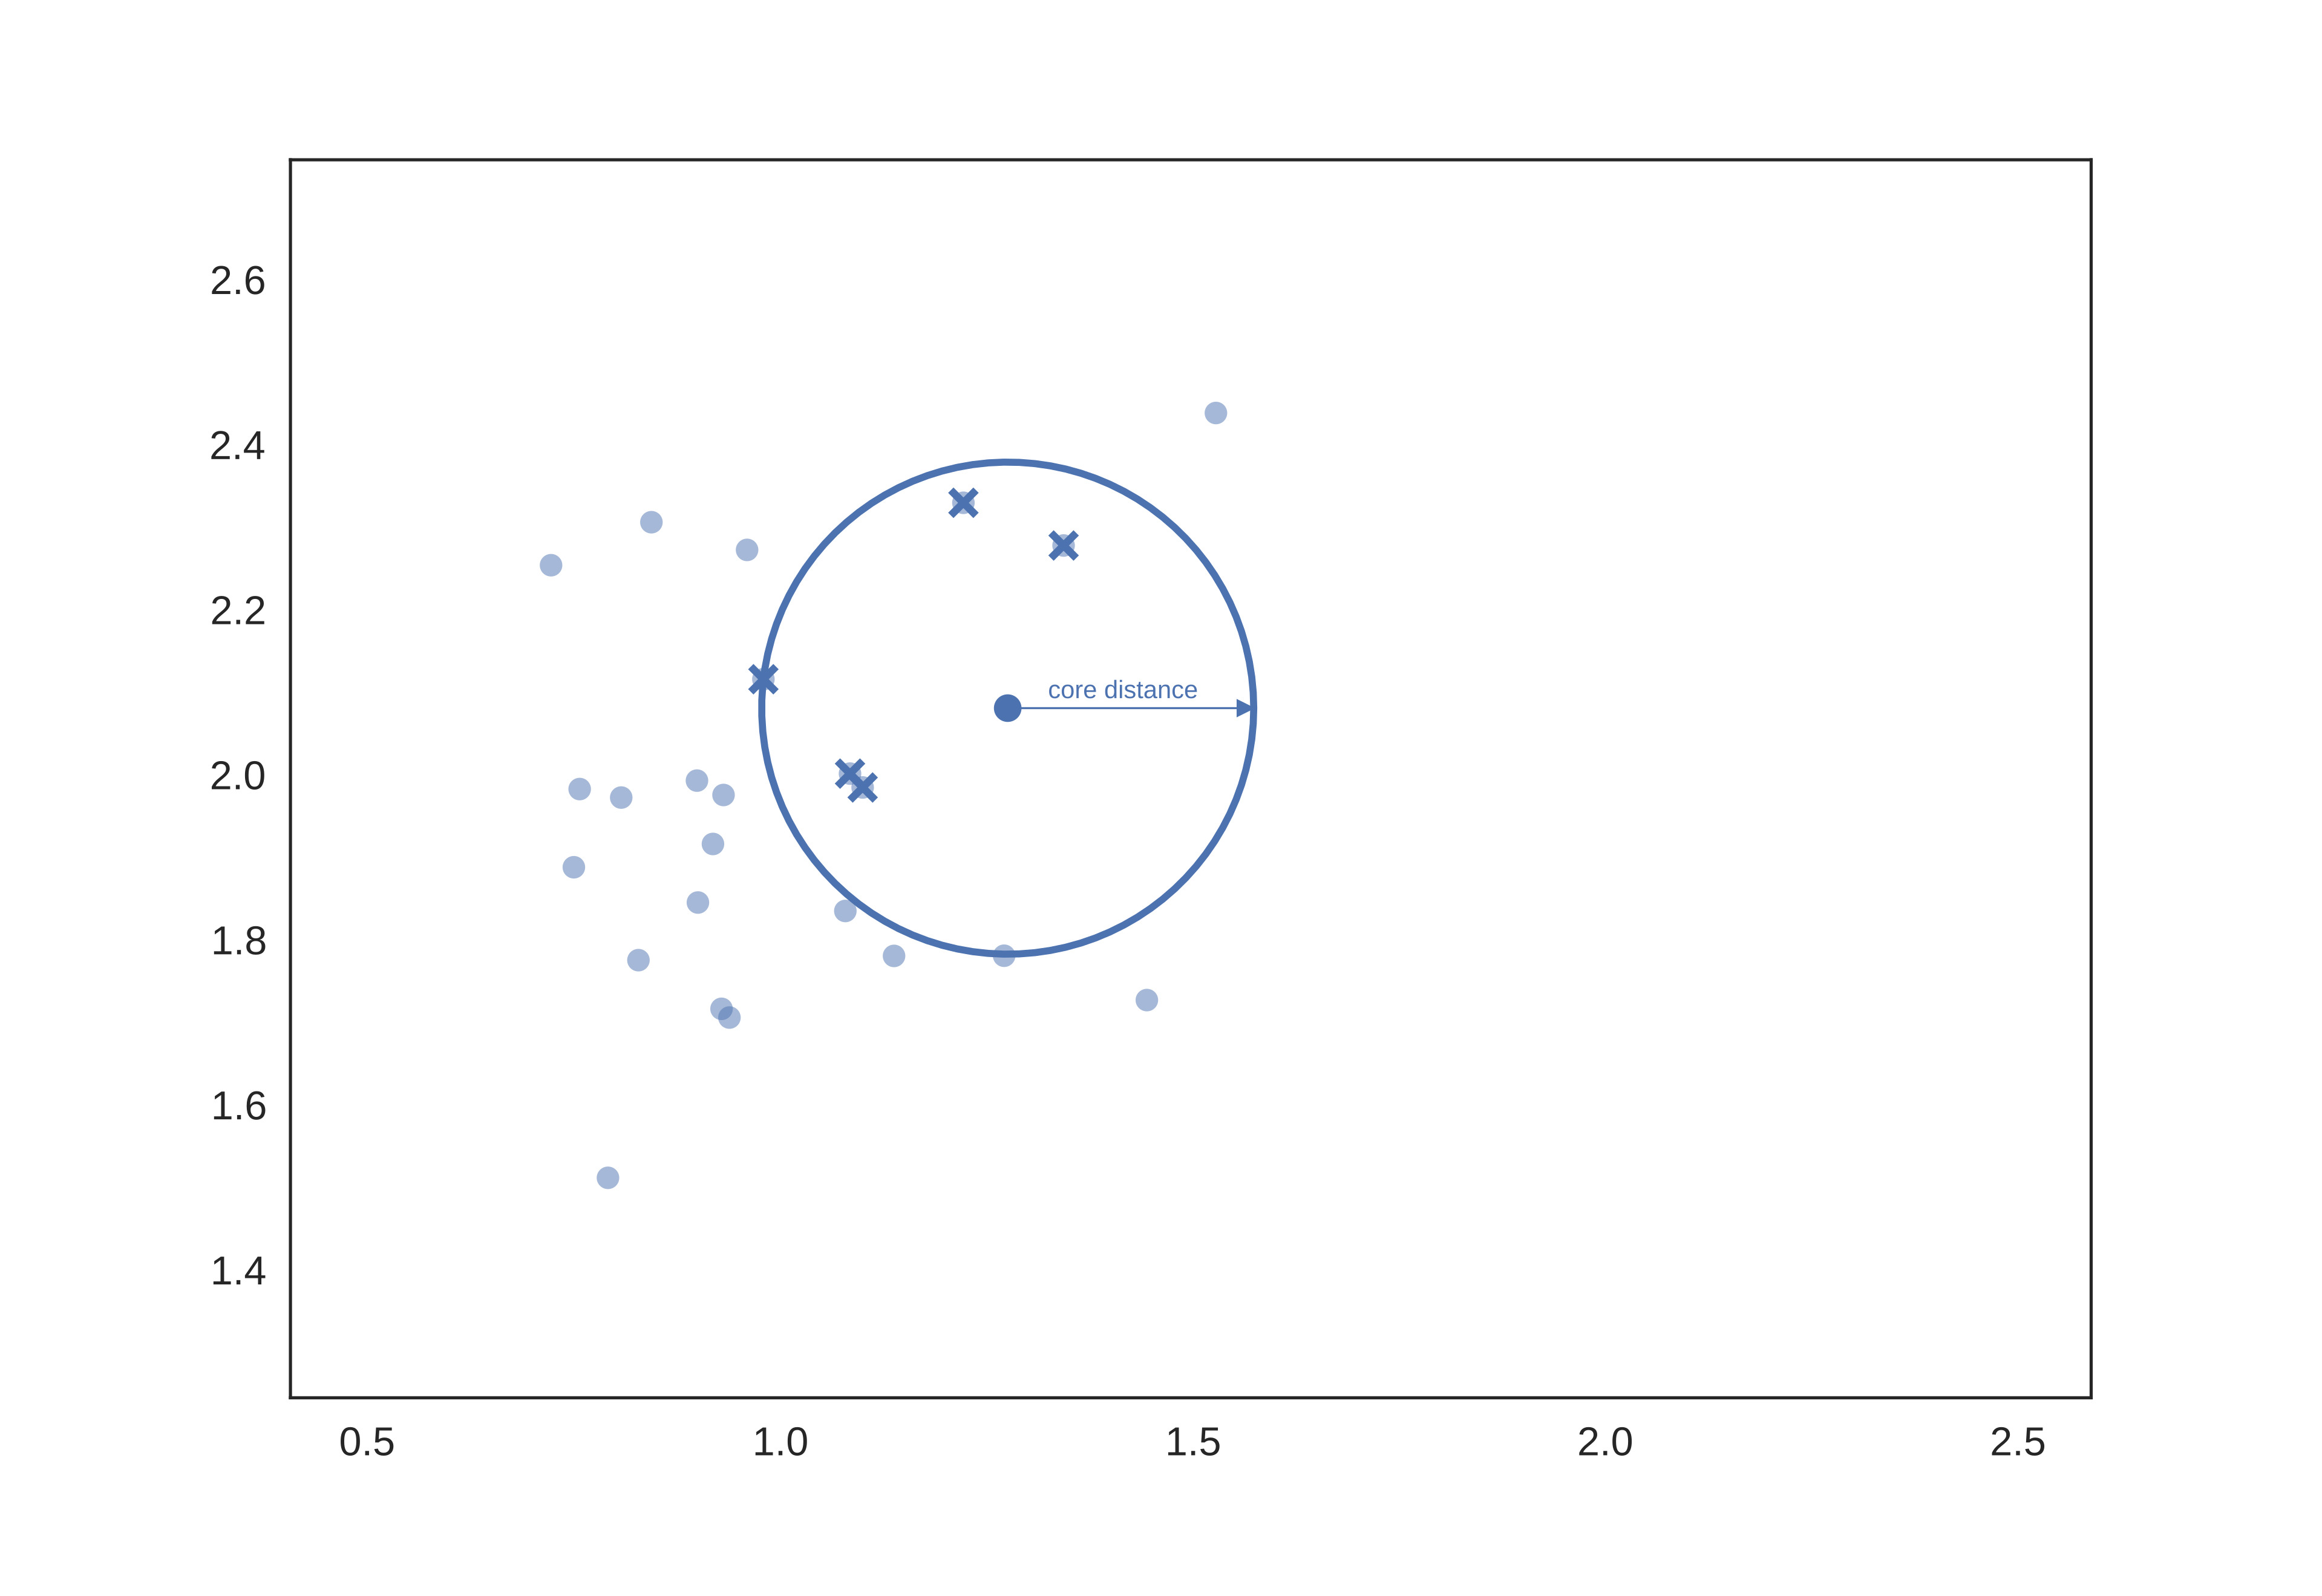

Pick another point and we can do the same thing, this time with a different set of neighbors (one of them even being the first point we picked out).

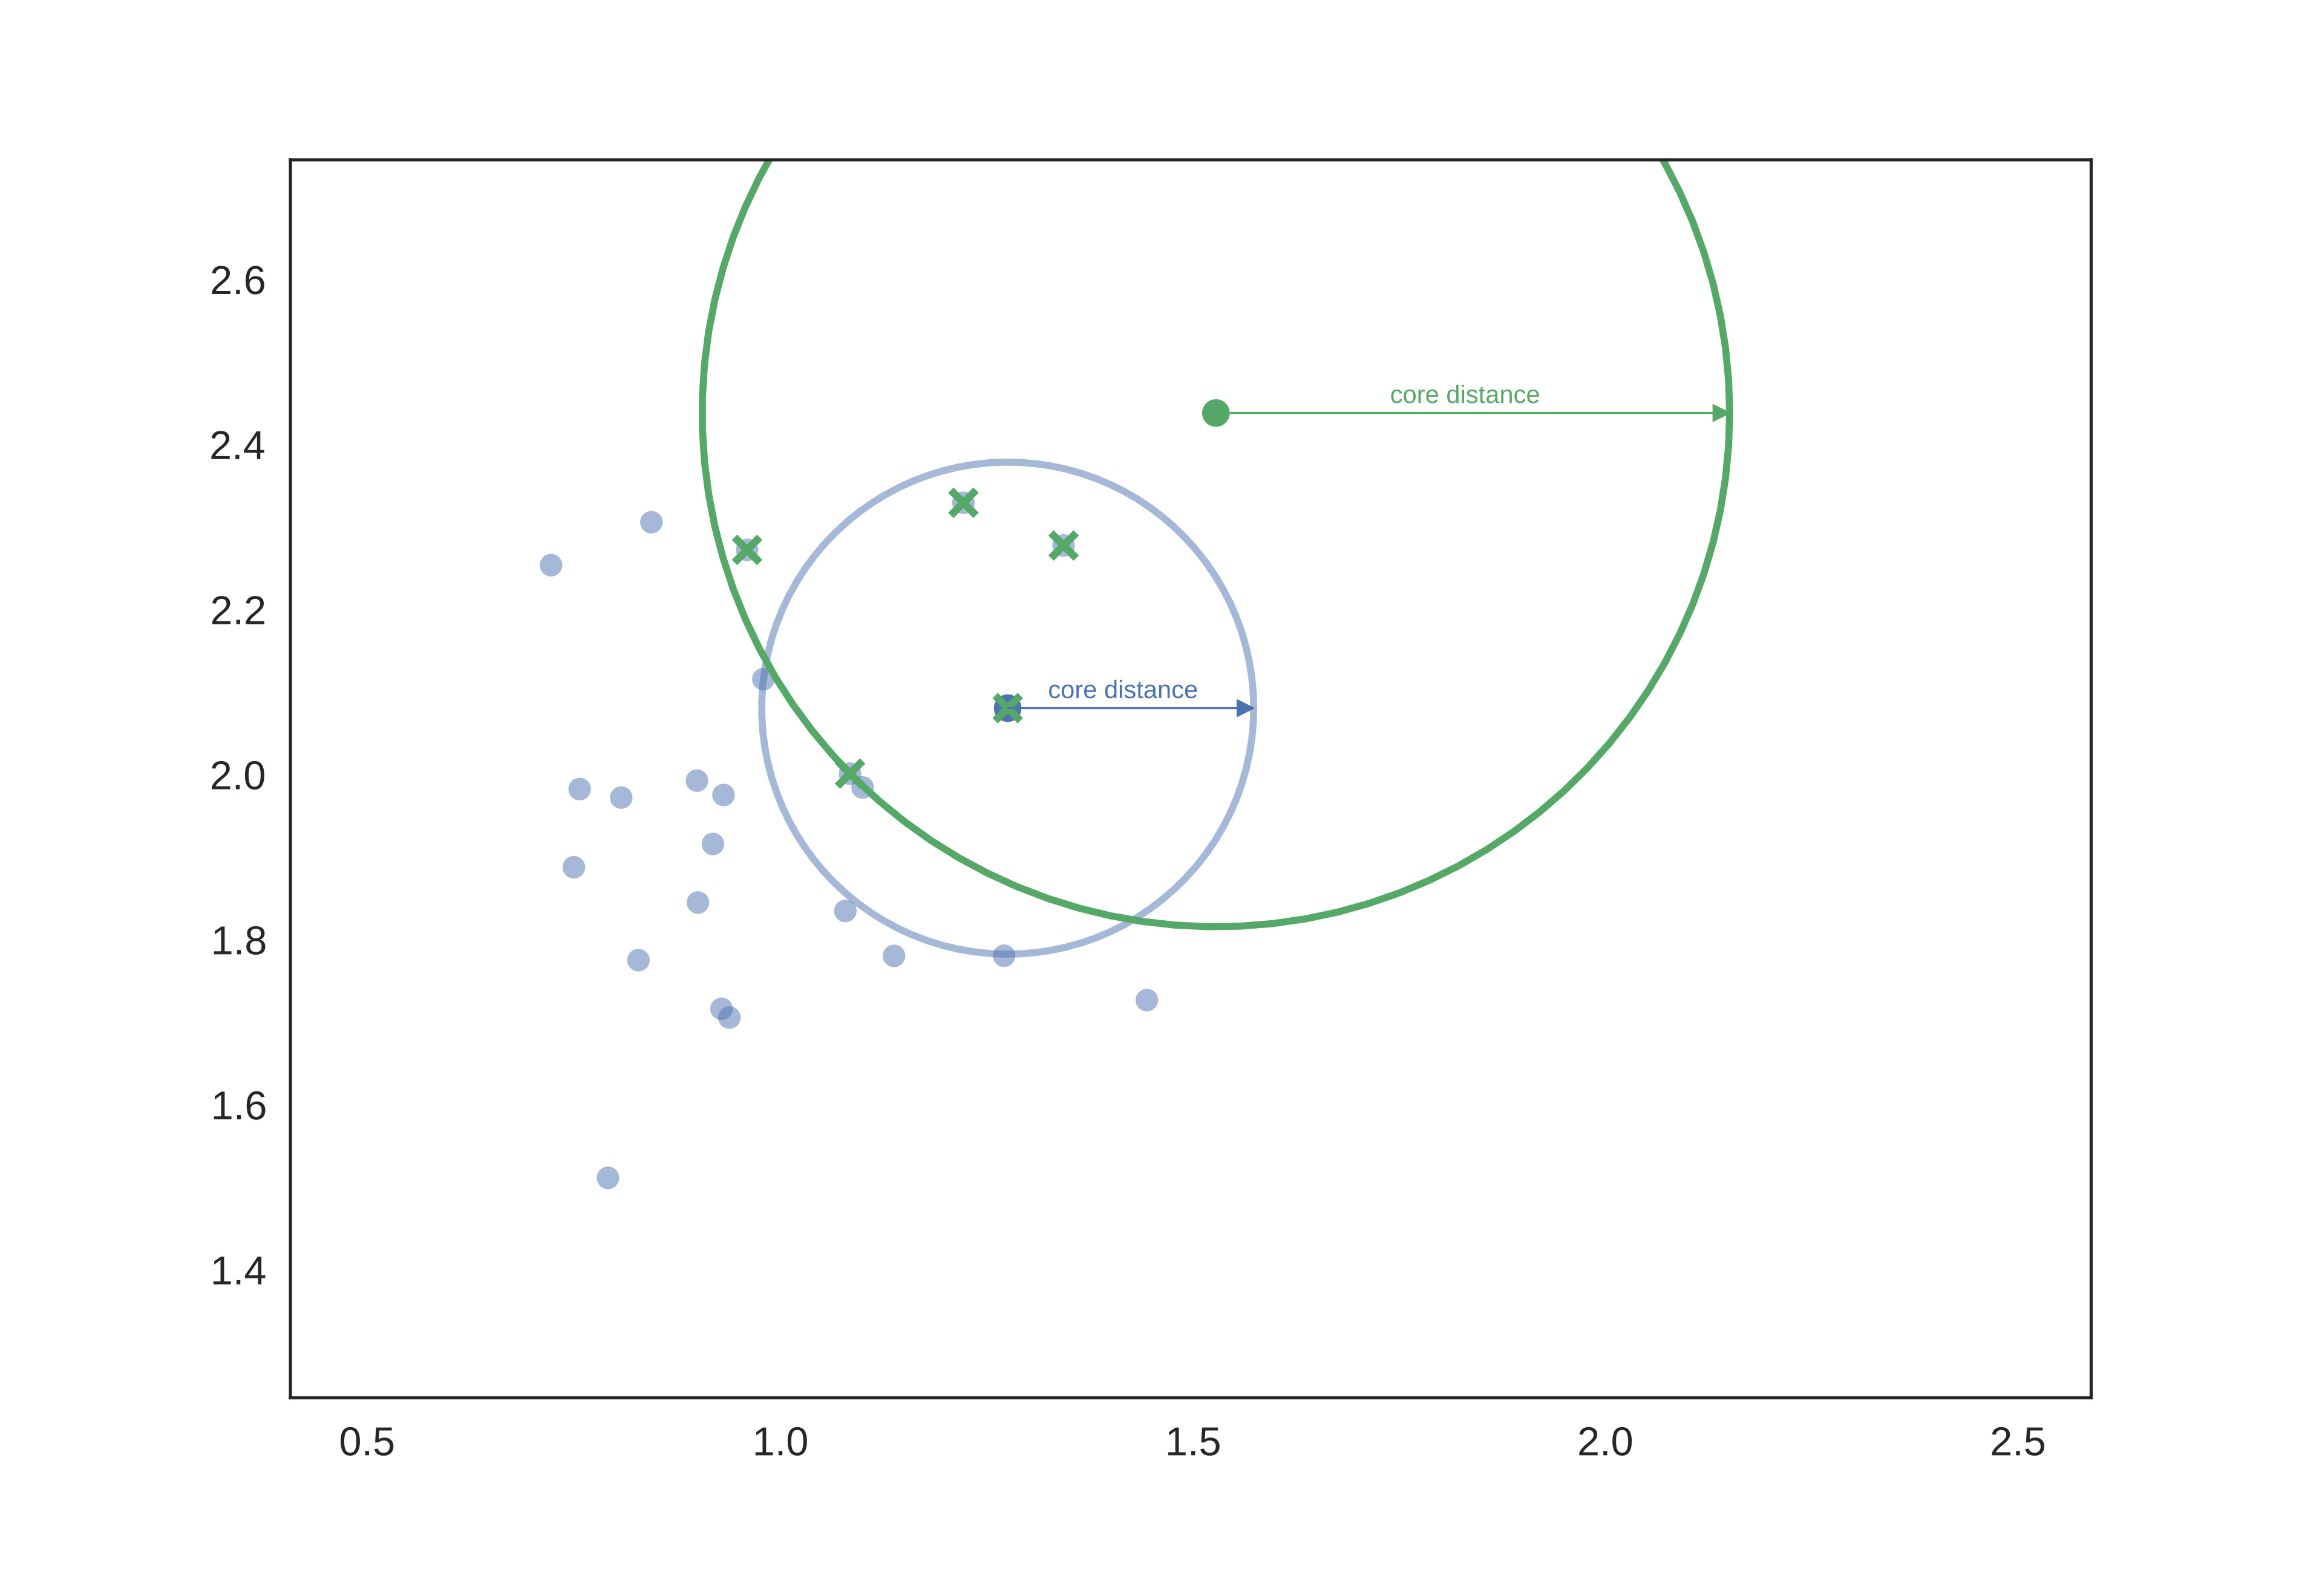

And we can do that a third time for good measure, with another set of six nearest neighbors and another circle with slightly different radius again.

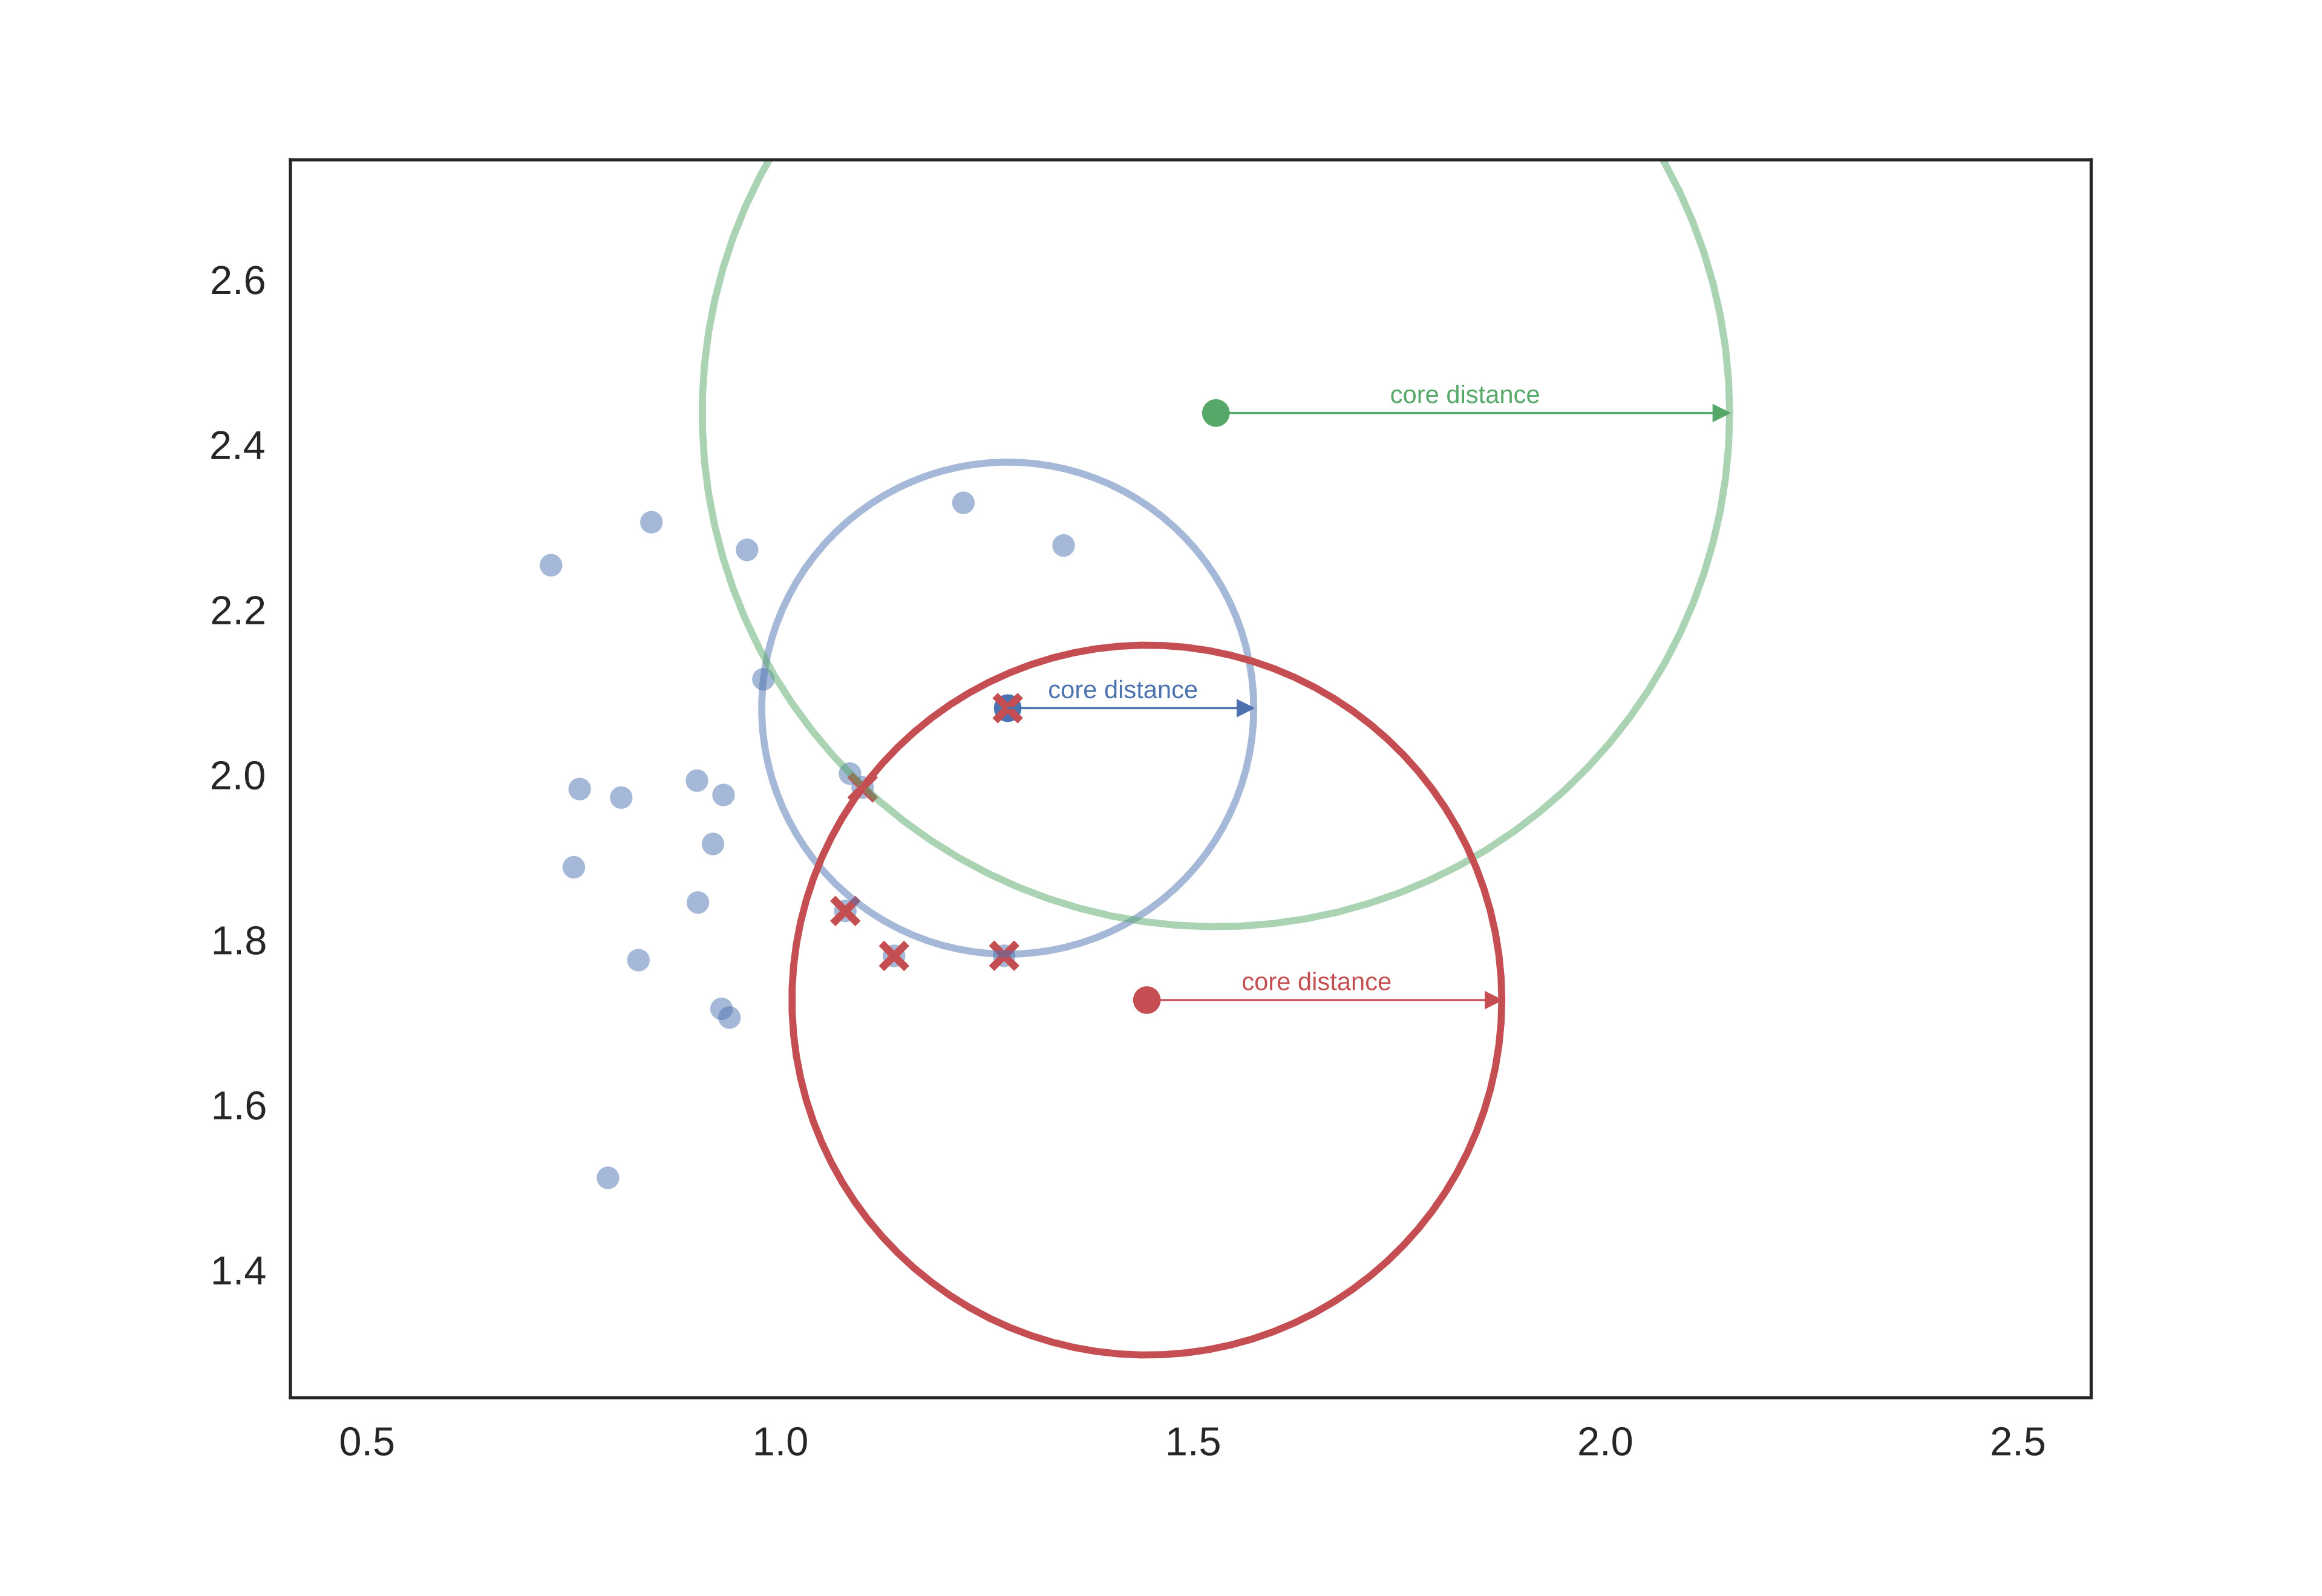

To determine the mutual reachability distance between two points (in this case, the blue and green points), you can start by drawing an arrow that represents the distance between the two points. The arrow indicates the reachability distance from one point to the other.

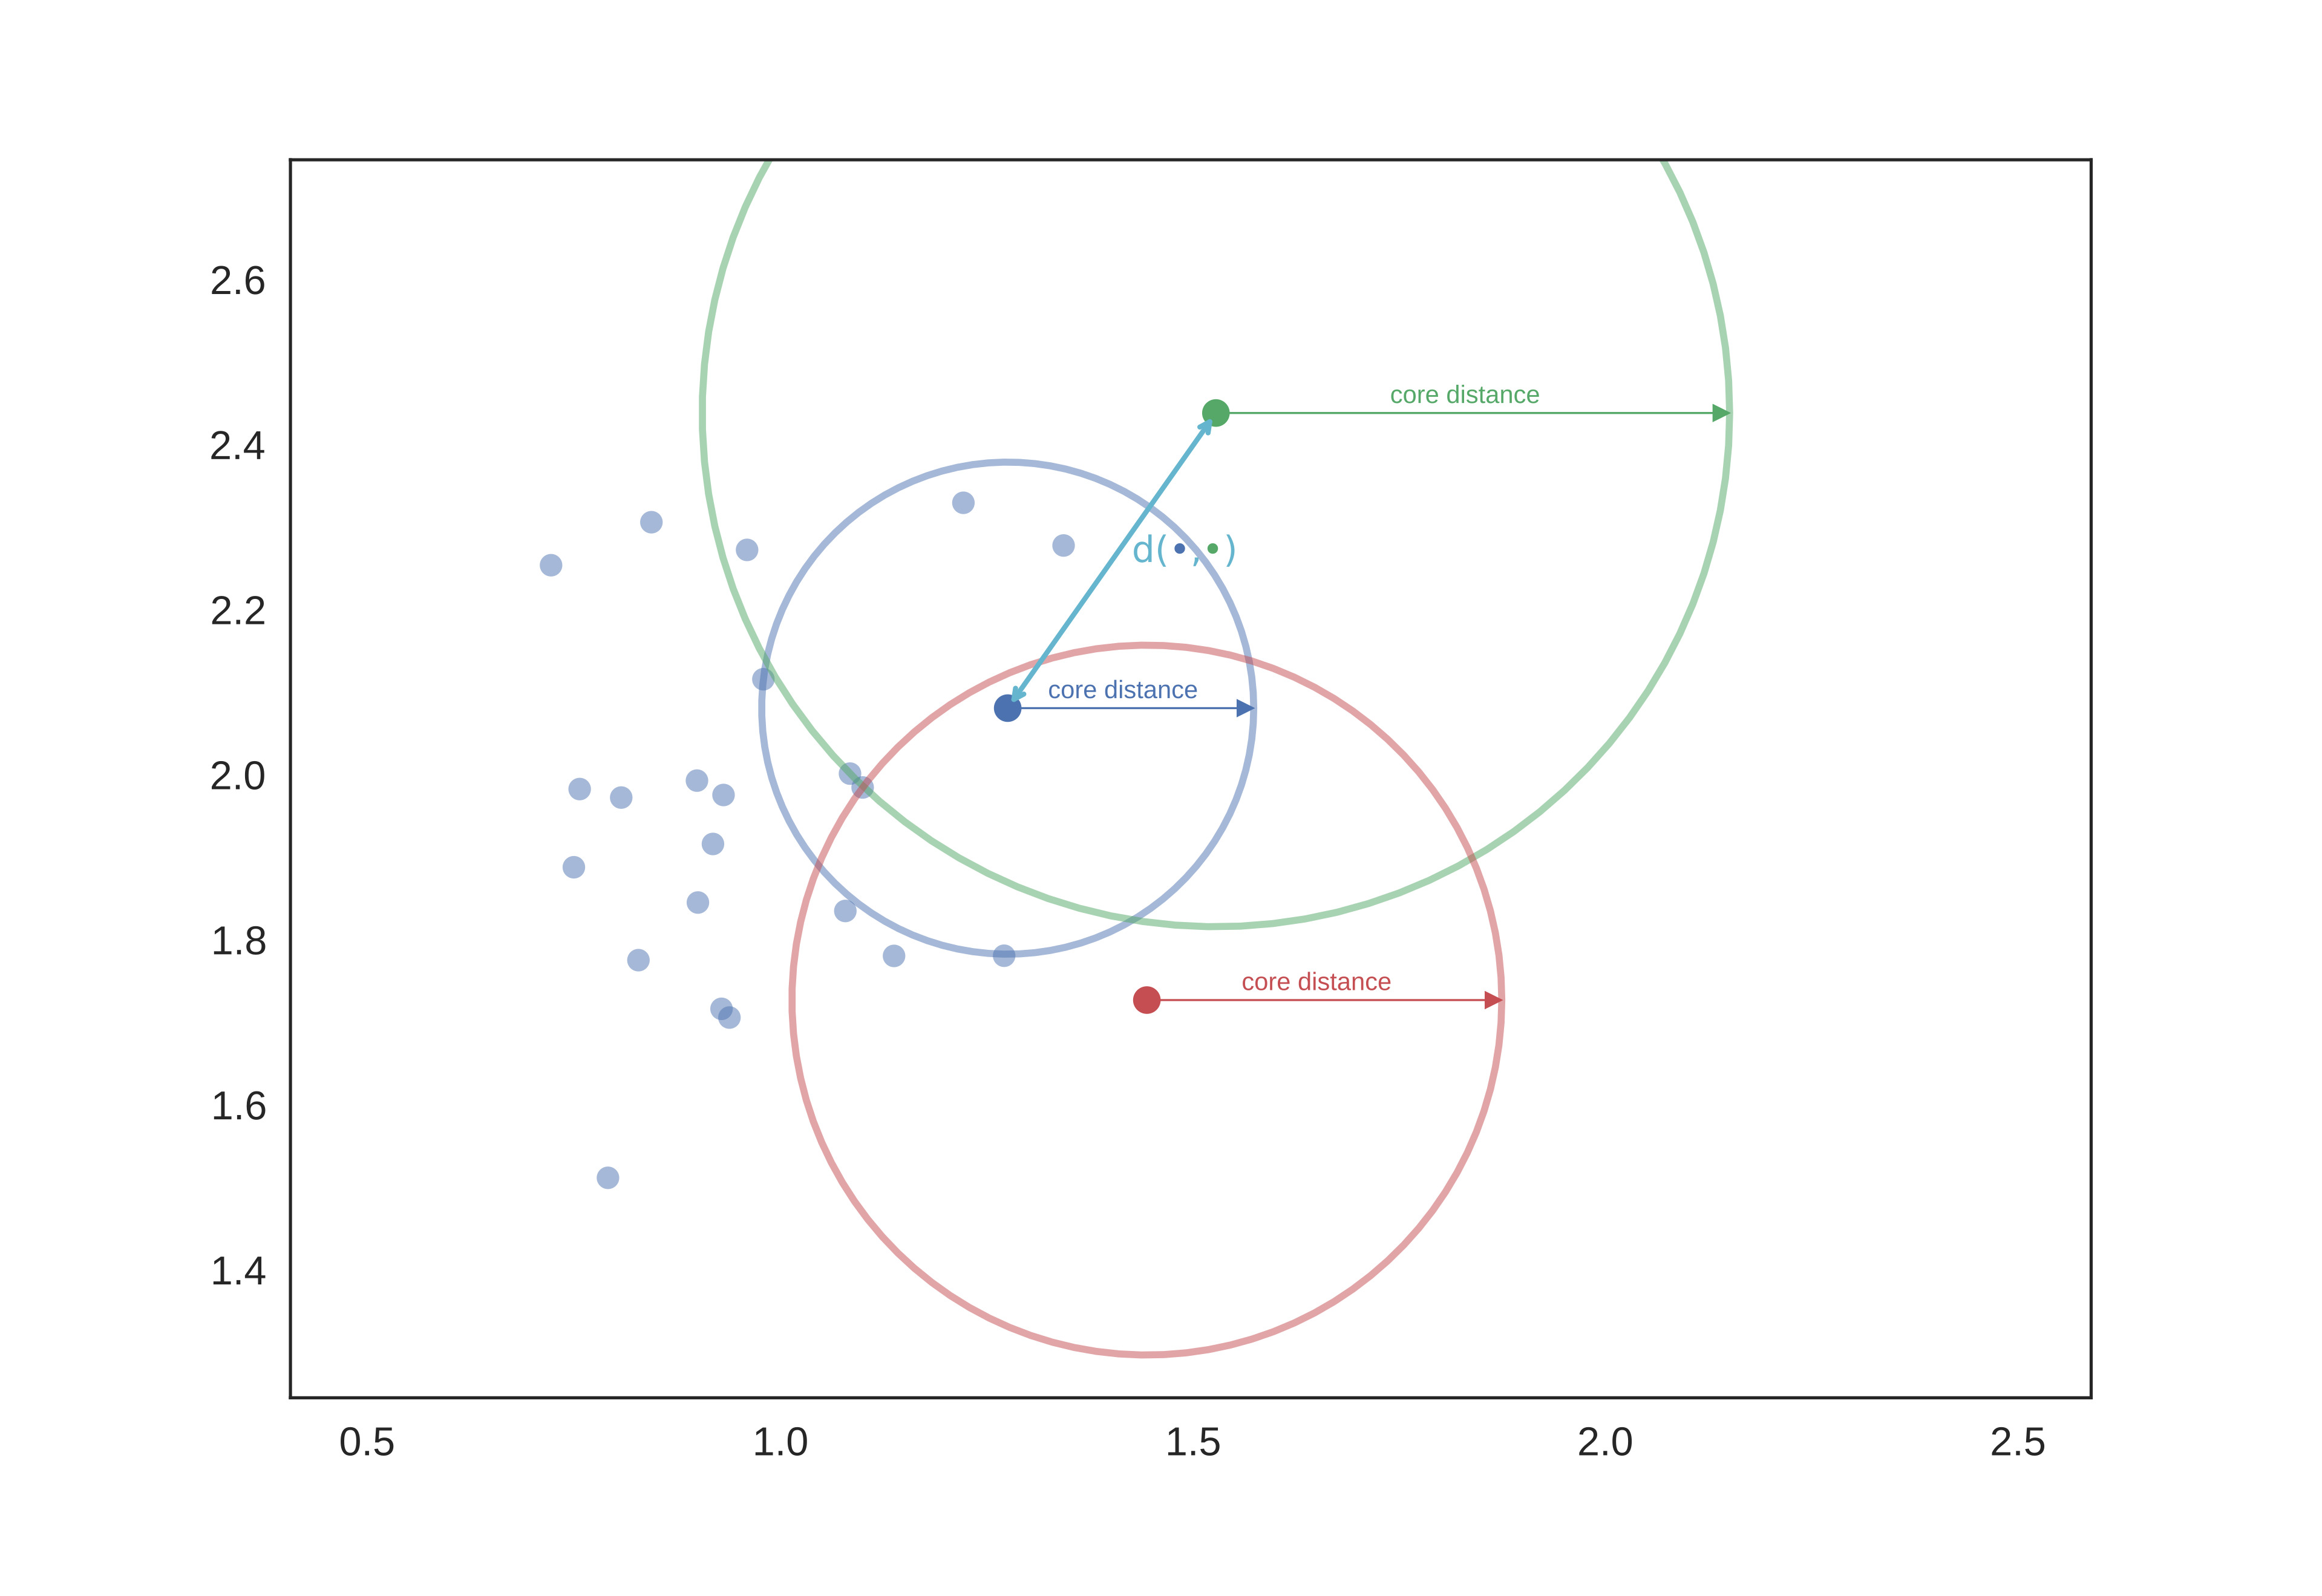

This passes through the blue circle, but not the green circle -- the core distance for green is larger than the distance between blue and green. Thus we need to mark the mutual reachability distance between blue and green as larger -- equal to the radius of the green circle

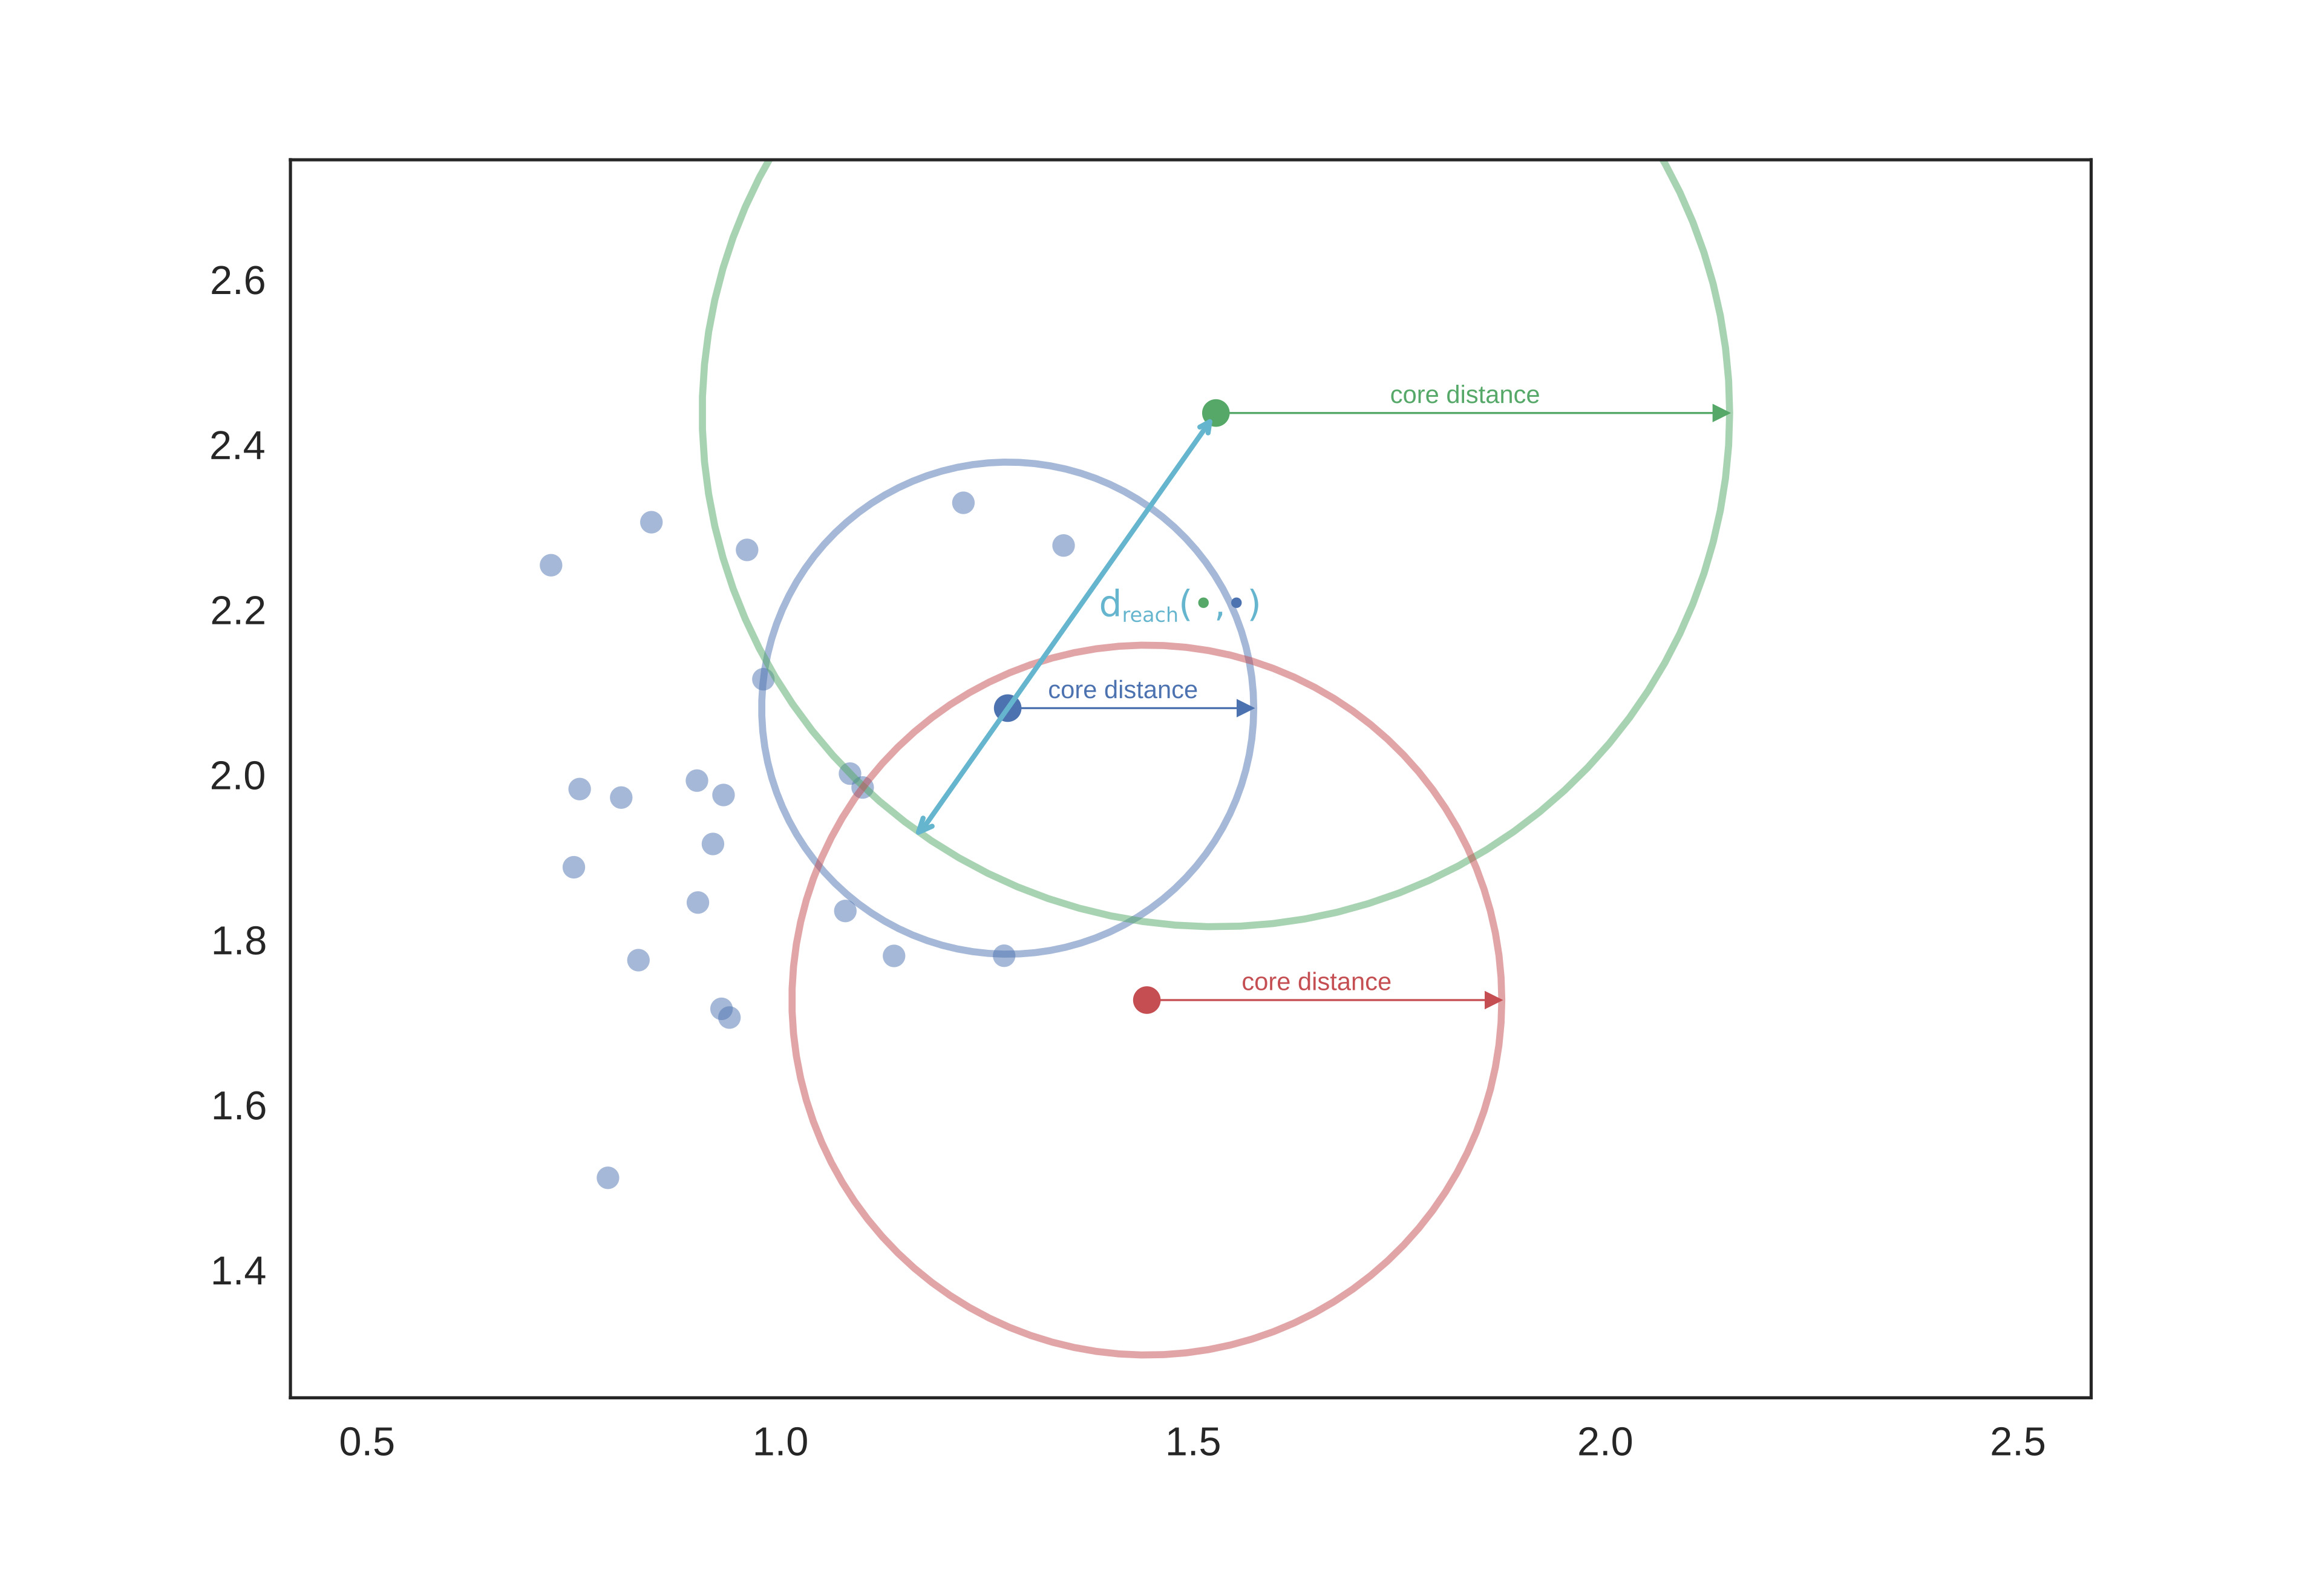

On the other hand the mutual reachablity distance from red to green is simply distance from red to green since that distance is greater than either core distance (i.e. the distance arrow passes through both circles).

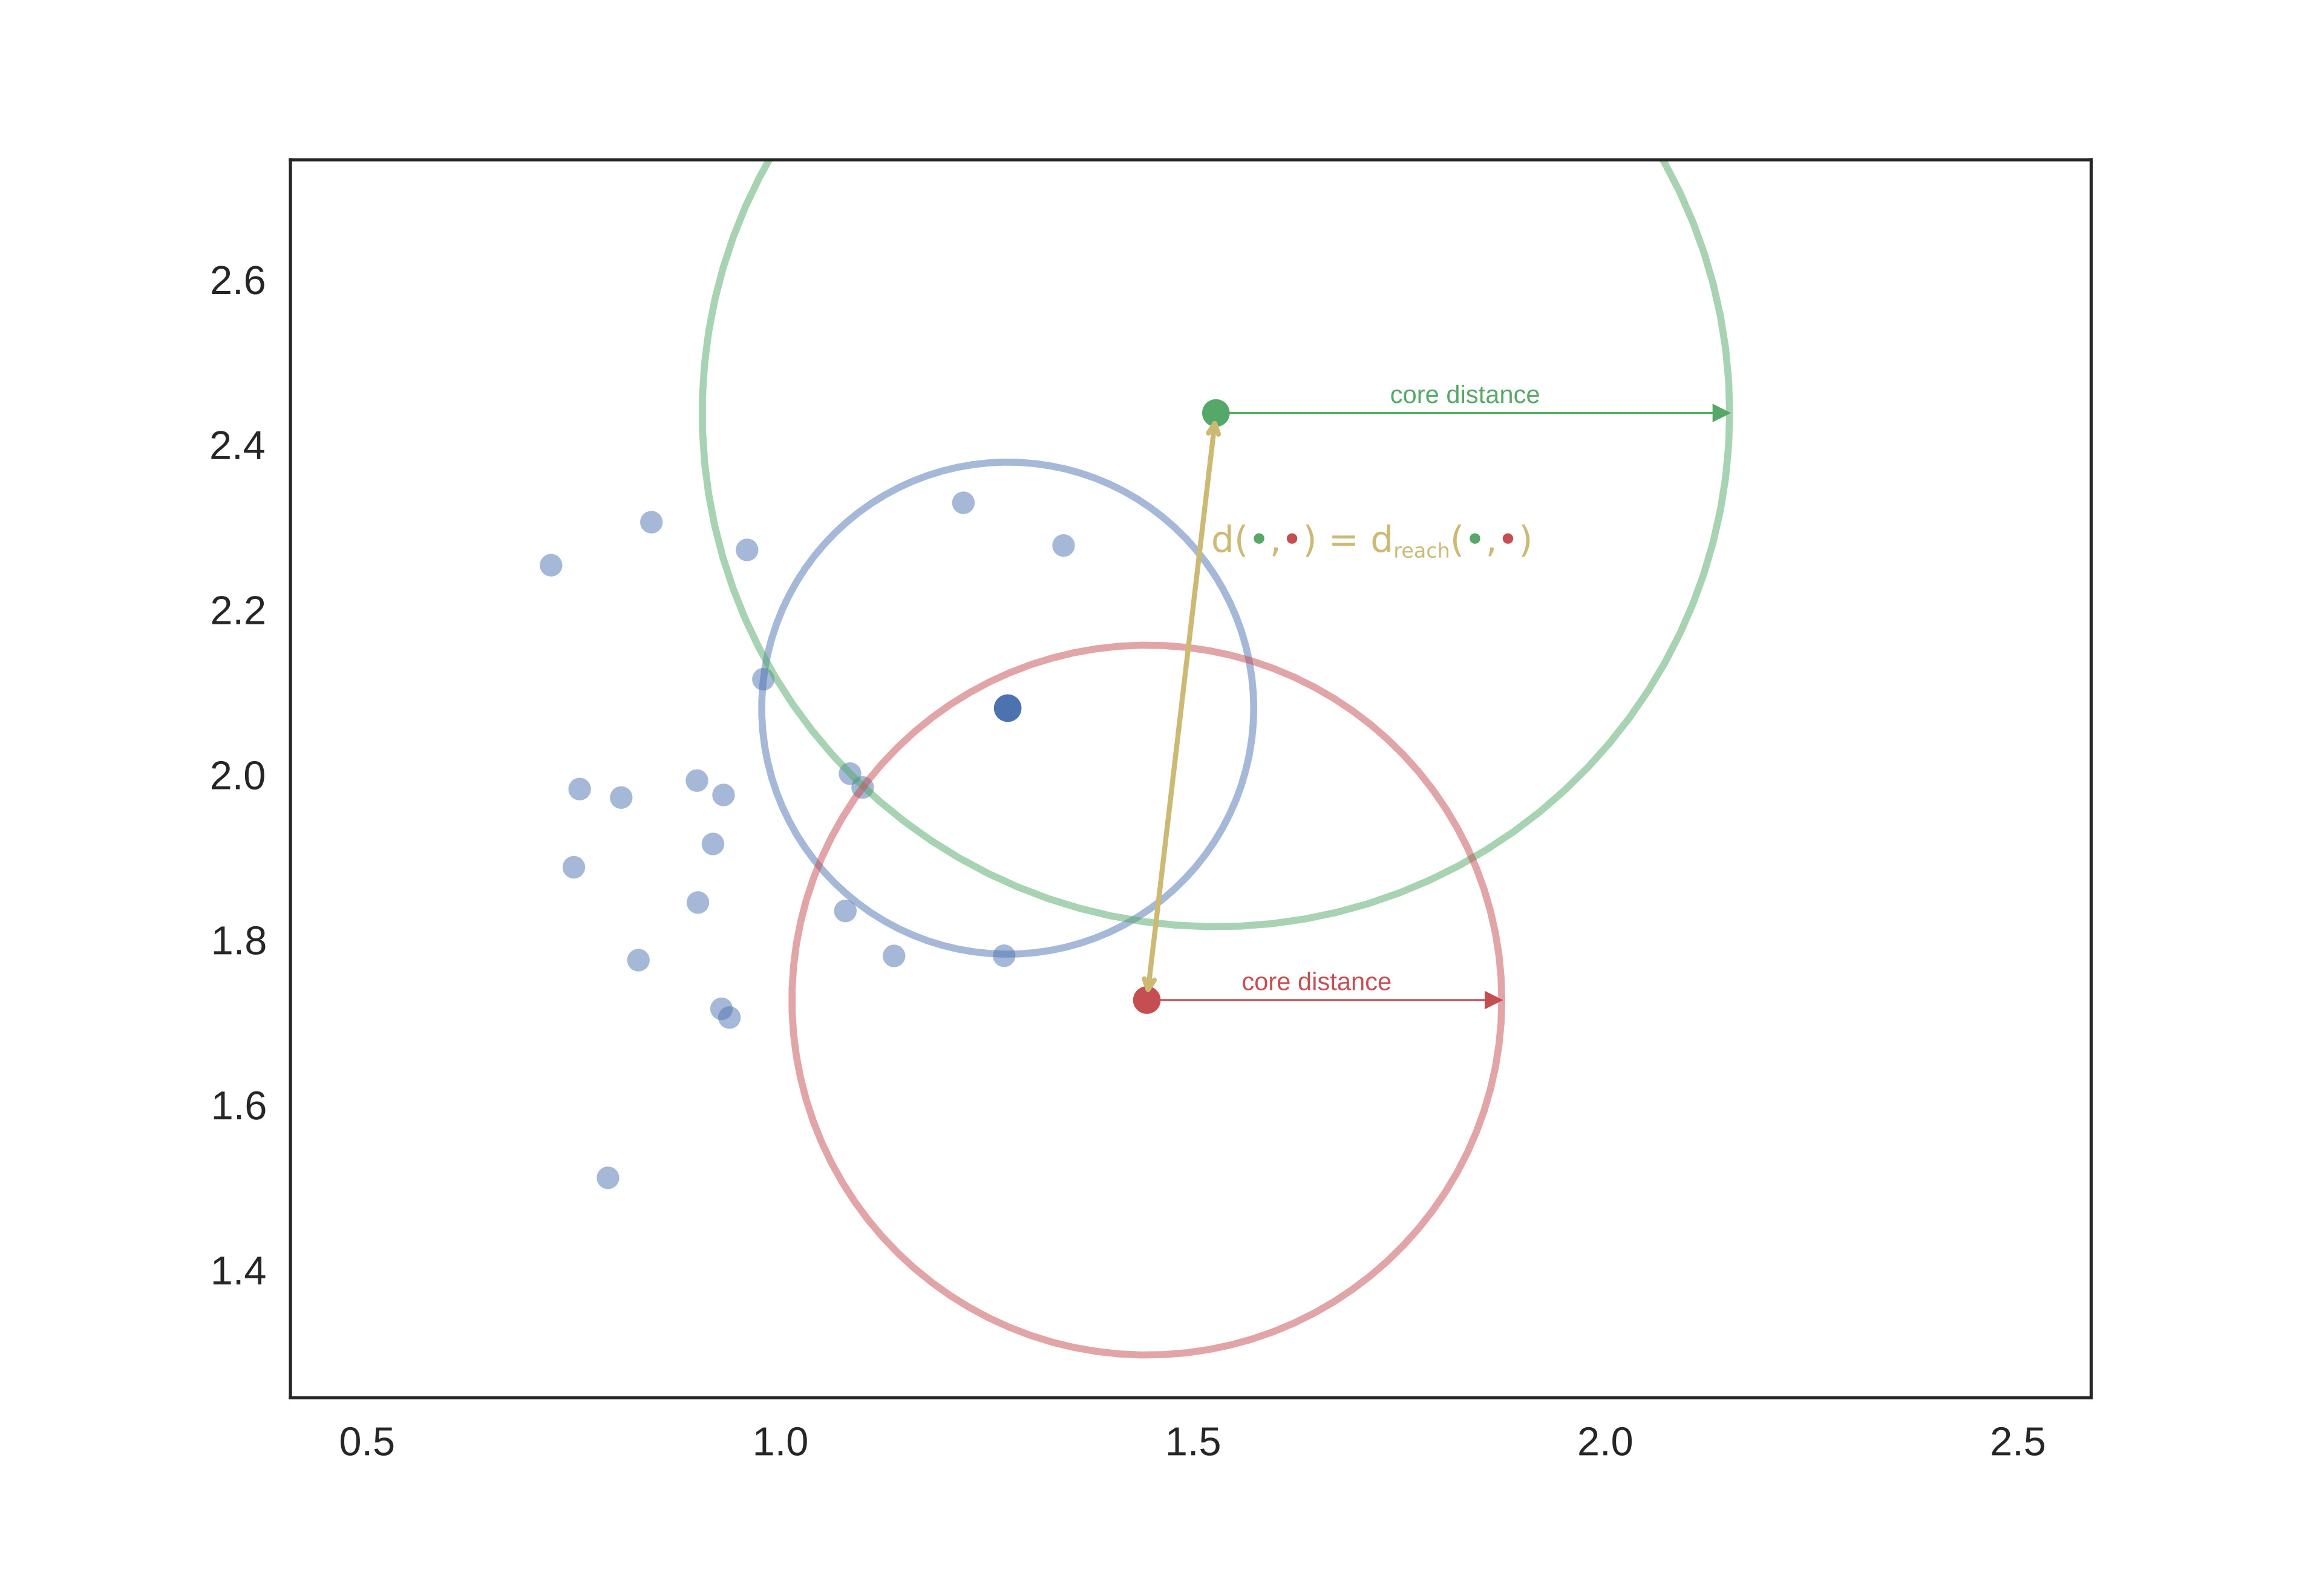

#### 2. Build the minimum spanning tree

- To find clusters in dense data, we can consider the data as a weighted graph with mutual reachability distances as edge weights.
- By gradually lowering a threshold, we can drop edges above that threshold and disconnect the graph into connected components, forming a hierarchy.
- Finding the minimal set of edges that disconnect components without lower weight connections is essential, and the minimum spanning tree of the graph serves this purpose.

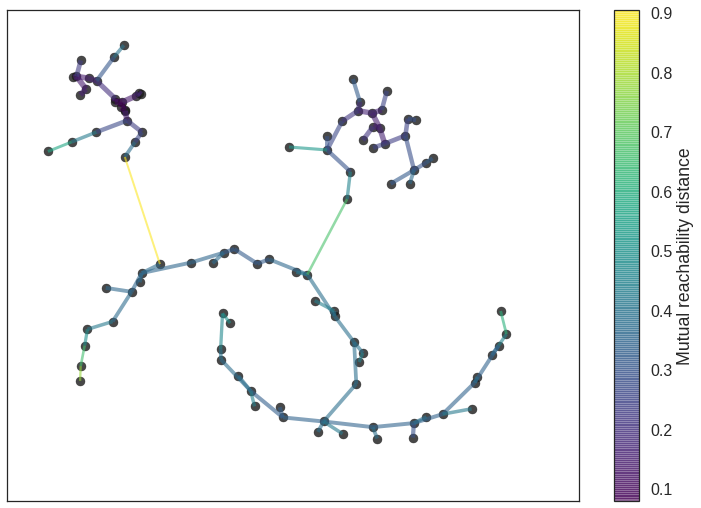

#### 3. Build the cluster hierarchy

- Given the minimal spanning tree, the next step is to convert it into a hierarchy of connected components.
- This is achieved by sorting the edges of the tree by distance in increasing order and creating a merged cluster for each edge.
- HDBSCAN allows the tree to be cut at different positions, enabling the selection of clusters at various density levels.

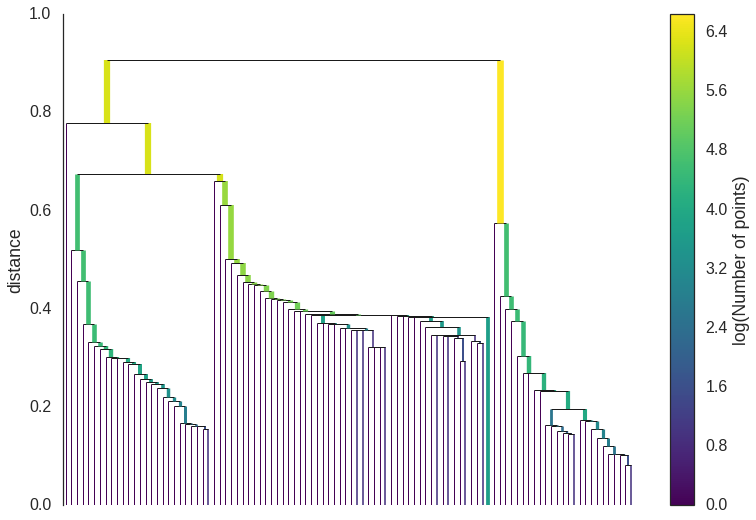

#### 4. Condense the cluster tree

- The first step in cluster extraction involves condensing the cluster hierarchy into a smaller tree.
- Instead of viewing a cluster split as two new clusters forming, consider it as a single persistent cluster losing points.
- Use minimum cluster size parameter and walk through the hierarchy to identify points falling out of a cluster to form a smaller tree with nodes indicating decreasing cluster size.
- Analyze the dendrogram and use the width of the lines representing the number of points in each cluster to obtain flat clusters.

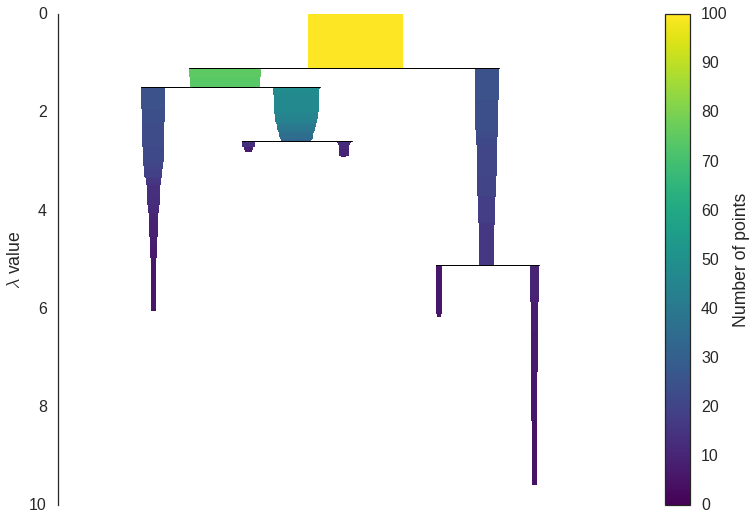

#### 5. Extract the clusters

- To choose persistent clusters with longer lifetimes, select clusters with the greatest area of ink in the plot.
- HDBSCAN achieves this by considering a measure called lambda (λ), which is the inverse of the distance.
- Lambda values, λ_birth and λ_death, indicate when a cluster split off and when it split into smaller clusters.
- Each point in a cluster has a lambda value (λ_p) indicating when it fell out of the cluster.
- Stability is computed for each cluster as the sum of (λ_p - λ_birth) for all points in the cluster.
    $\sum_{p \in \mathrm{cluster}} (\lambda_p - \lambda_{\mathrm{birth}})$.
- Leaf nodes are initially selected as clusters, and then a top-down traversal of the tree is performed.
- If the sum of child cluster stabilities exceeds the stability of a cluster, its stability is updated accordingly.
- If a cluster's stability is greater than the sum of its children, it is selected as a cluster, and its descendants are unselected.

- The resulting selected clusters form the flat clustering of the condensed tree dendrogram.


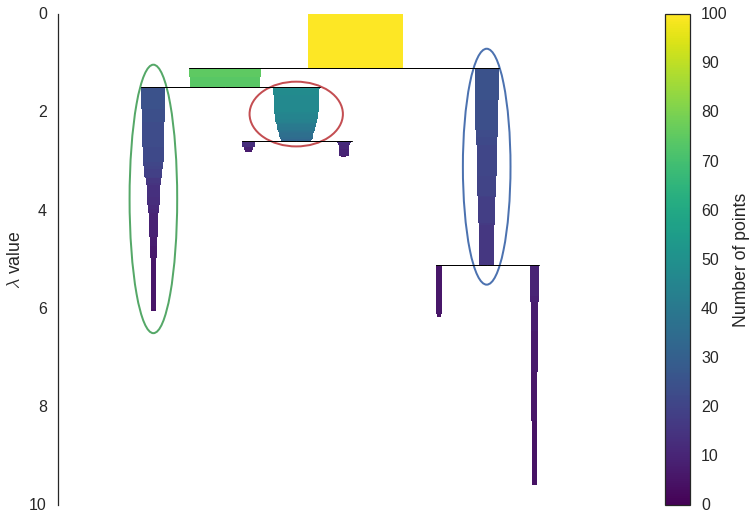

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Simple K-means clustering on the Iris dataset

In [2]:
# Load the Iris dataset
df_iris = sns.load_dataset('iris')
df_iris.head(10)

sepal_length  sepal_width  petal_length  petal_width species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa
5           5.4          3.9           1.7          0.4  setosa
6           4.6          3.4           1.4          0.3  setosa
7           5.0          3.4           1.5          0.2  setosa
8           4.4          2.9           1.4          0.2  setosa
9           4.9          3.1           1.5          0.1  setosa

In [3]:
# convert the dataframe into an array
array_iris = df_iris.iloc[:, [0, 1, 2, 3]].values
array_iris

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

#### Elbow method
It allows to pick the optimal number of clusters for clustering. 
Although we already know the answer is 3 it is still interesting to run.

In [4]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


Text(0, 0.5, 'WCSS')

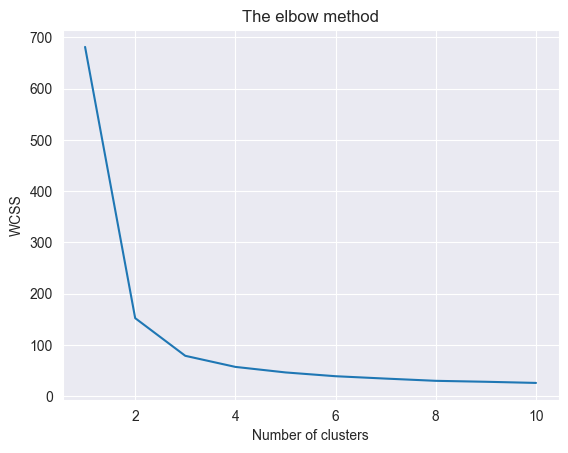

In [5]:
# Finding the optimum number of clusters for k-means classification
from sklearn.cluster import KMeans
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(array_iris)
    wcss.append(kmeans.inertia_)
    
#Plotting the results onto a line graph, allowing us to observe 'The elbow'
plt.plot(range(1, 11), wcss)
plt.title('The elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS') #within cluster sum of squares

You can clearly see why it is called 'The elbow method' from the above graph, the optimum clusters is where the elbow occurs. This is when the within cluster sum of squares (WCSS) doesn't decrease significantly with every iteration. Now that we have the optimum amount of clusters, we can move on to applying K-means clustering to the Iris dataset.

In [6]:
#Applying kmeans to the dataset
kmeans = KMeans(n_clusters = 3, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
y_kmeans = kmeans.fit_predict(array_iris)
y_kmeans

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2,
       2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0], dtype=int32)

#### Plot the clustering results using Matplotlib

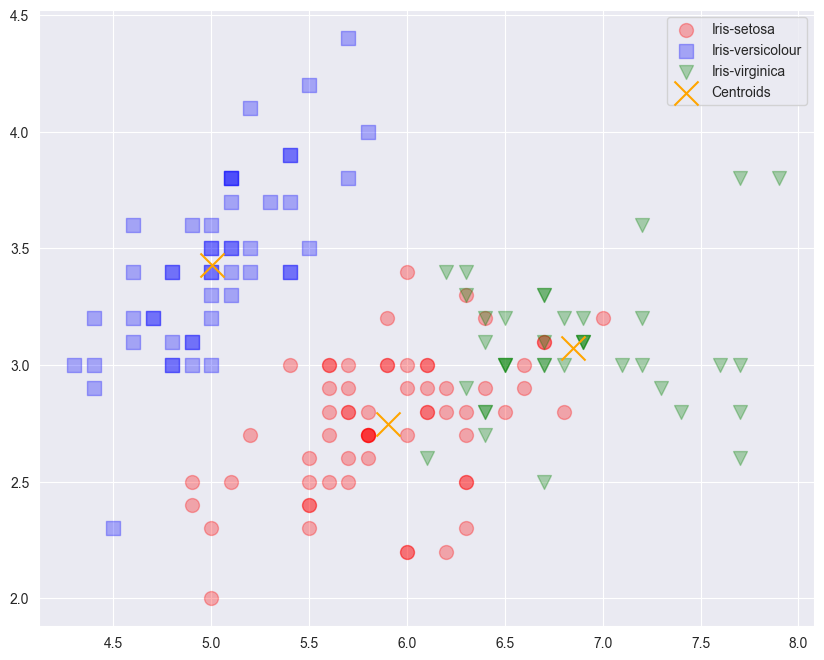

In [7]:
# Define the colors and markers for each class
colors = ['red', 'blue', 'green']
markers = ['o', 's', 'v']
labels = ['Iris-setosa', 'Iris-versicolour', 'Iris-virginica']

# Create a new figure with a larger size
plt.figure(figsize=(10, 8))

# Visualize the clusters on the first two features
for i in range(len(labels)):
    plt.scatter(array_iris[y_kmeans == i, 0], array_iris[y_kmeans == i, 1], s=100, c=colors[i], marker=markers[i], label=labels[i], alpha=0.3)

# Plot the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='orange', marker='x', label='Centroids')

plt.legend()

#### Plot the clustering results using Seaborn

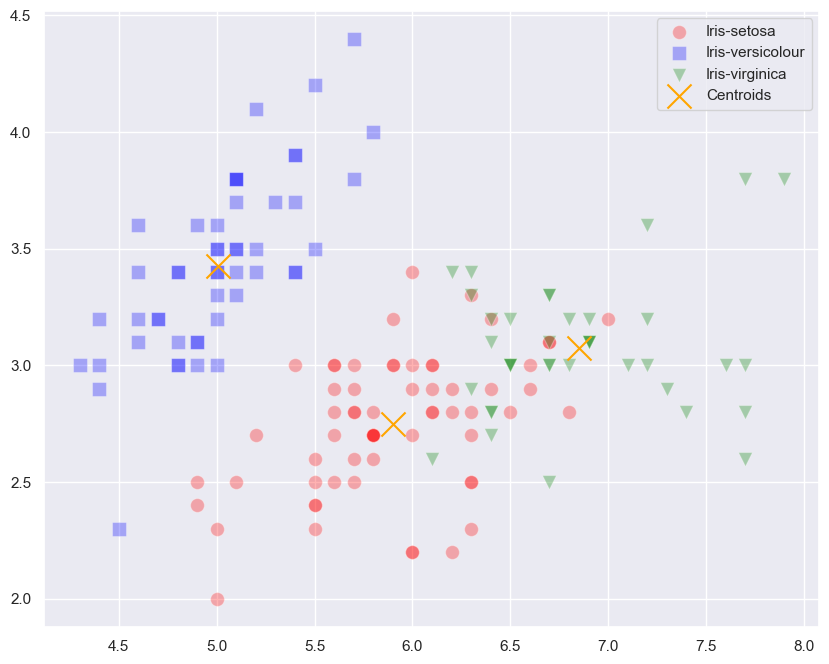

In [8]:
# Define the colors and markers for each class
colors = ['red', 'blue', 'green']
markers = ['o', 's', 'v']
labels = ['Iris-setosa', 'Iris-versicolour', 'Iris-virginica']

# Set the style to use Seaborn
sns.set()

# Create a new figure with a larger size
plt.figure(figsize=(10, 8))

# Visualize the clusters on the first two features
for i in range(len(labels)):
    sns.scatterplot(x=array_iris[y_kmeans == i, 0], y=array_iris[y_kmeans == i, 1], s=100, color=colors[i], marker=markers[i], label=labels[i], alpha=0.3)

# Plot the centroids of the clusters
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='orange', marker='x', label='Centroids')

plt.legend()

## Hierarchical clustering

In [9]:
df_iris

sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [20.0, 20.0, 40.0, 40.0],
  [55.0, 55.0, 65.0, 65.0],
  [85.0, 85.0, 95.0, 95.0],
  [75.0, 75.0, 90.0, 90.0],
  [60.0, 60.0, 82.5, 82.5],
  [30.0, 30.0, 71.25, 71.25],
  [5.0, 5.0, 50.625, 50.625],
  [105.0, 105.0, 115.0, 115.0],
  [125.0, 125.0, 135.0, 135.0],
  [145.0, 145.0, 155.0, 155.0],
  [130.0, 130.0, 150.0, 150.0],
  [110.0, 110.0, 140.0, 140.0],
  [165.0, 165.0, 175.0, 175.0],
  [195.0, 195.0, 205.0, 205.0],
  [185.0, 185.0, 200.0, 200.0],
  [170.0, 170.0, 192.5, 192.5],
  [125.0, 125.0, 181.25, 181.25],
  [27.8125, 27.8125, 153.125, 153.125]],
 'dcoord': [[0.0, 0.24494897427831785, 0.24494897427831785, 0.0],
  [0.0, 0.47958315233127163, 0.47958315233127163, 0.0],
  [0.24494897427831785,
   0.5477225575051661,
   0.5477225575051661,
   0.47958315233127163],
  [0.0, 0.24494897427831788, 0.24494897427831788, 0.0],
  [0.0, 0.22360679774997827, 0.22360679774997827, 0.0],
  [0.0, 0.4690415759823426, 0.469041575982

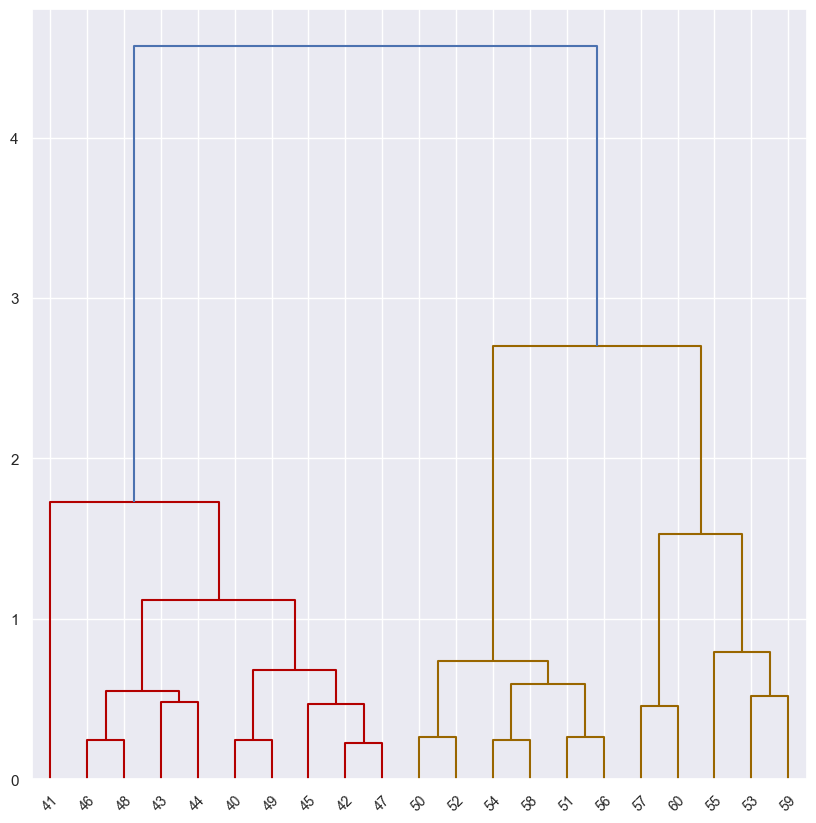

In [10]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster import hierarchy


plt.rcParams["figure.figsize"] = (10,10)

sub_df_iris = df_iris.drop('species', axis=1)

# Get the 40th-60th instances from the original dataset for making the clustering
sub_df_40_60 = sub_df_iris.iloc[40:61,:]

# Calculate the distance between each sample
# Severals methods can be used: single, complete, average, ward, centroid, weighted
Z = linkage(sub_df_40_60, method='complete')

# Set the colour of the cluster here:
hierarchy.set_link_color_palette(['#b30000','#996600'])

# Make the dendrogram and give the colour above threshold
hierarchy.dendrogram(Z, labels=sub_df_40_60.index,leaf_rotation = 45, leaf_font_size = 10)

#### Plot the Heatmap

Text(92.25, 0.5, 'Samples')

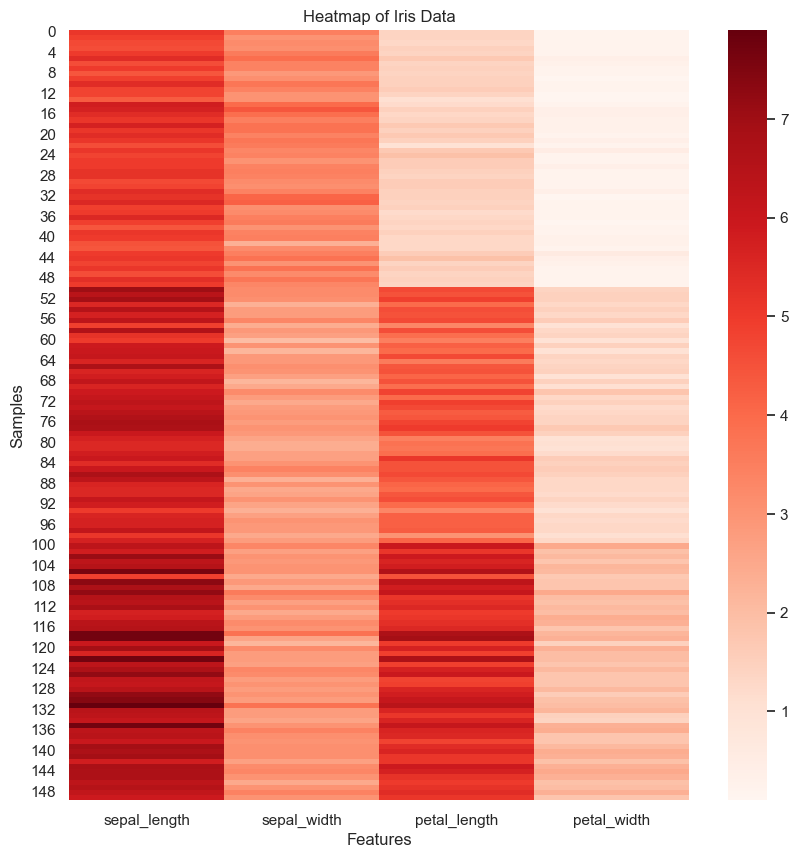

In [11]:
plt.rcParams["figure.figsize"] = (10, 10)

sub_df_iris = df_iris.drop('species', axis=1)

# Plotting the heatmap
sns.heatmap(sub_df_iris, cmap="Reds")

plt.title("Heatmap of Iris Data")
plt.xlabel("Features")
plt.ylabel("Samples")

#### Plot a Dendrogram with heatmap

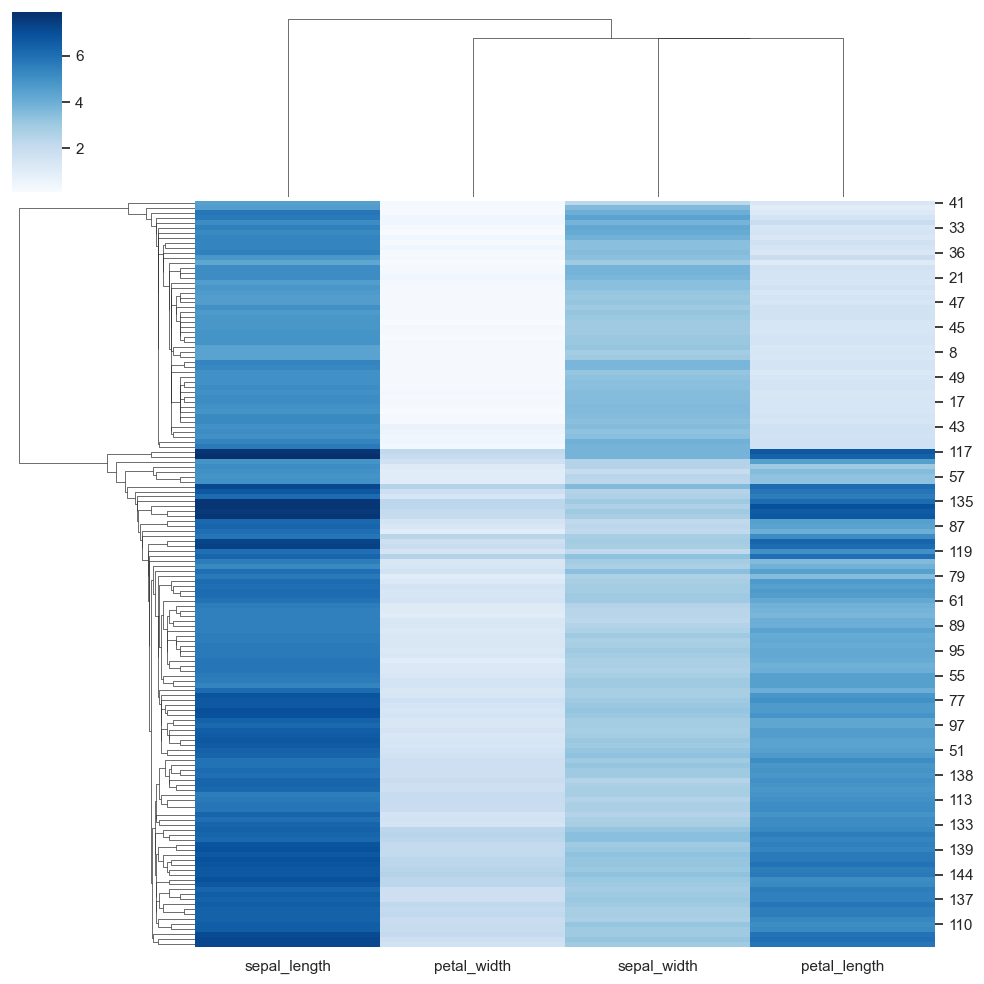

In [12]:
# Load the Iris dataset again
df_iris = sns.load_dataset('iris')

# Extract the features (columns) for clustering, remove the label column 'species'
sub_df_iris = df_iris.drop('species', axis=1)

# Plot the clustermap without Standardize or Normalize every column in the figure
sns.clustermap(sub_df_iris, cmap="Blues", method="single")

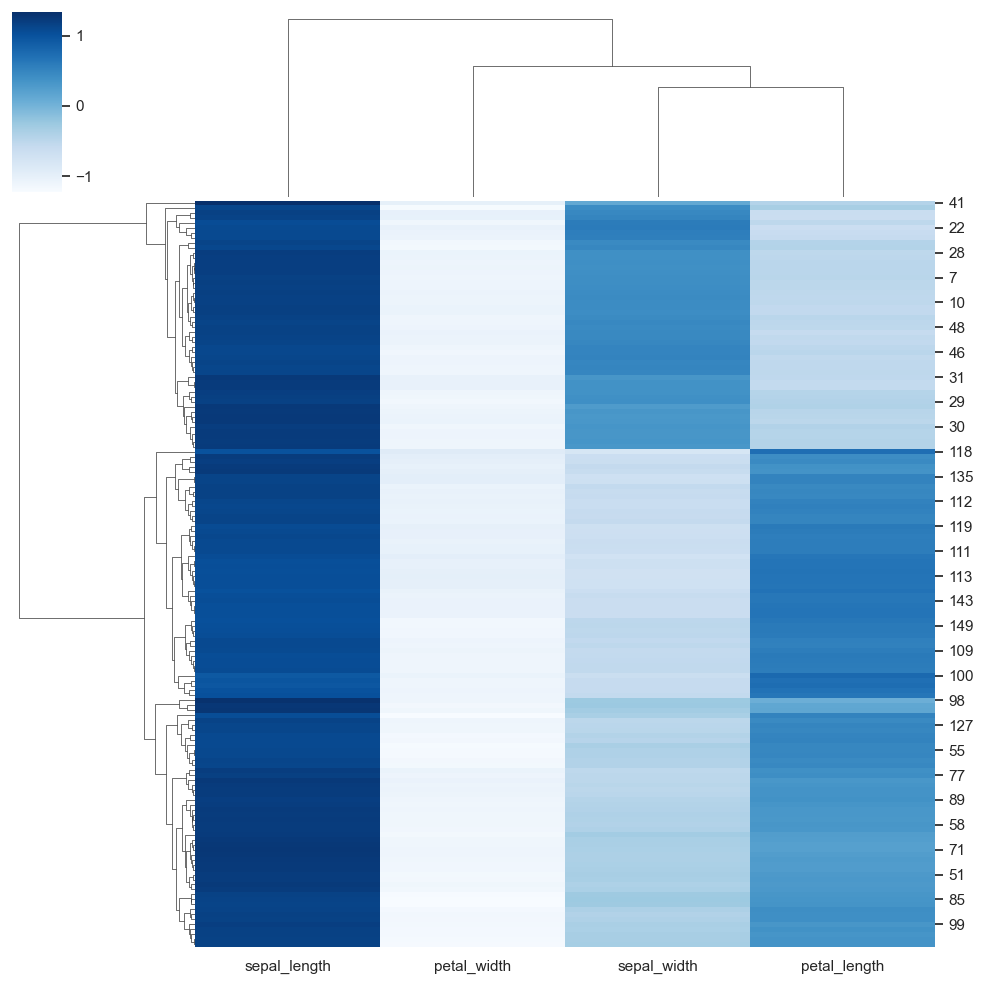

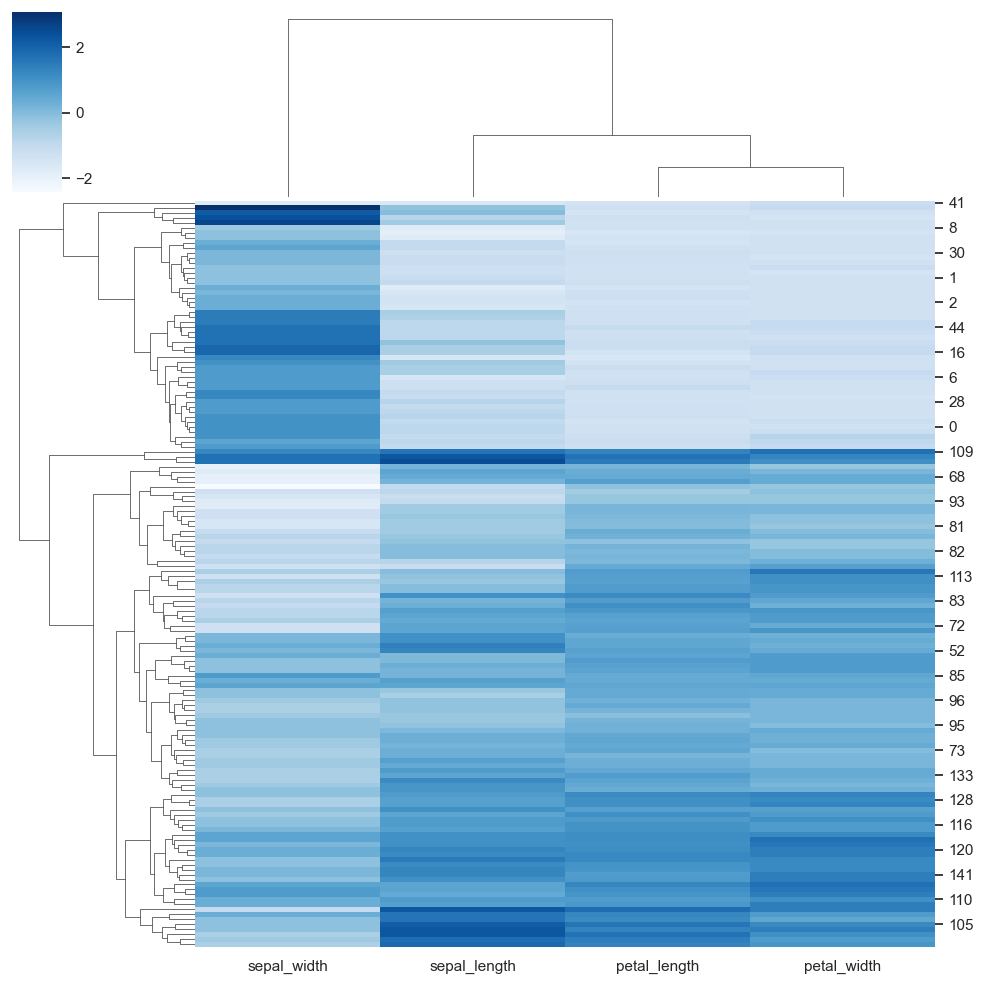

In [13]:
# Load the Iris dataset from seaborn
df_iris = sns.load_dataset('iris')

# Extract the features (columns) for clustering
sub_df_iris = df_iris.drop('species', axis=1)

# Plot the clustermap with Normalize every column in the figure
    # z_score : Either 0 (rows) or 1 (columns)
sns.clustermap(sub_df_iris, cmap="Blues", z_score=0)

sns.clustermap(sub_df_iris, cmap="Blues", z_score=1)

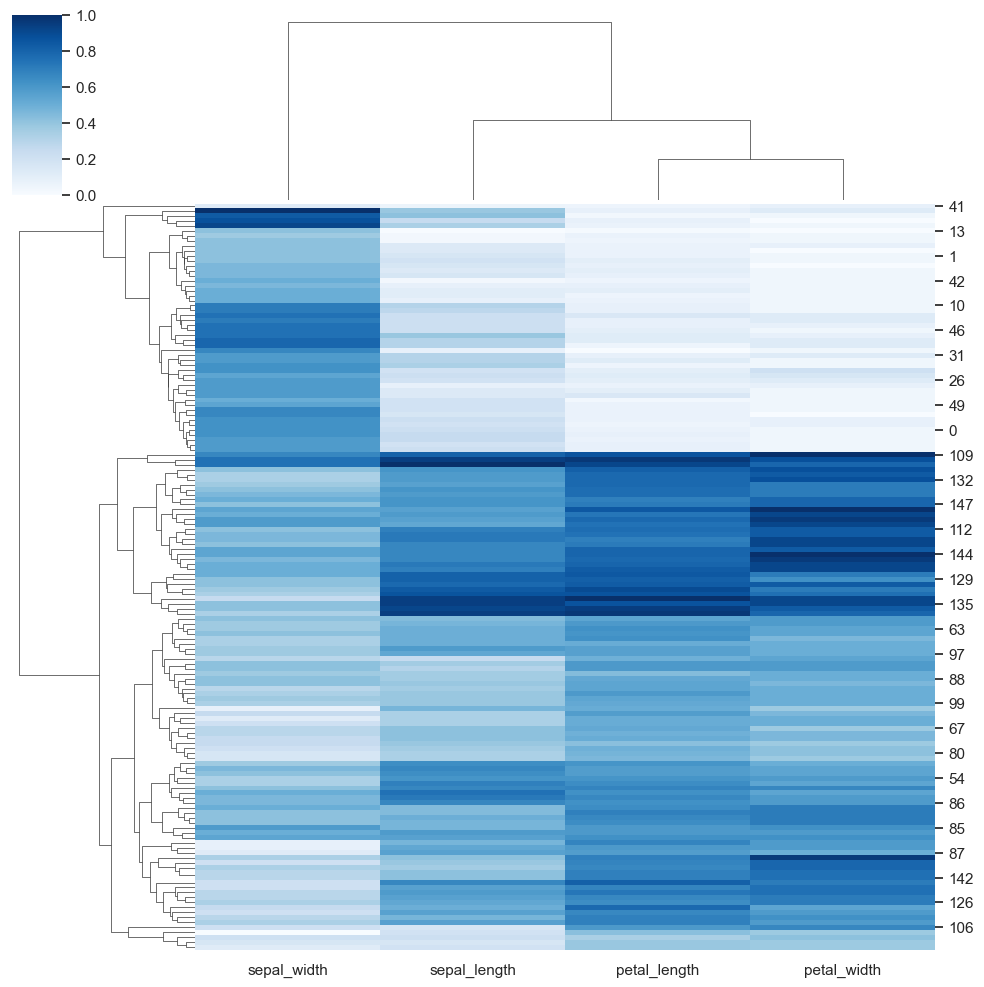

In [14]:
# Load the Iris dataset from seaborn
df_iris = sns.load_dataset('iris')

# Extract the features (columns) for clustering
sub_df_iris = df_iris.drop('species', axis=1)

# Plot the clustermap with Standardize every column in the figure
    # standard_scale : Either 0 (rows) or 1 (columns)

sns.clustermap(sub_df_iris, cmap="Blues", standard_scale=1)

#### Use different Distance Method

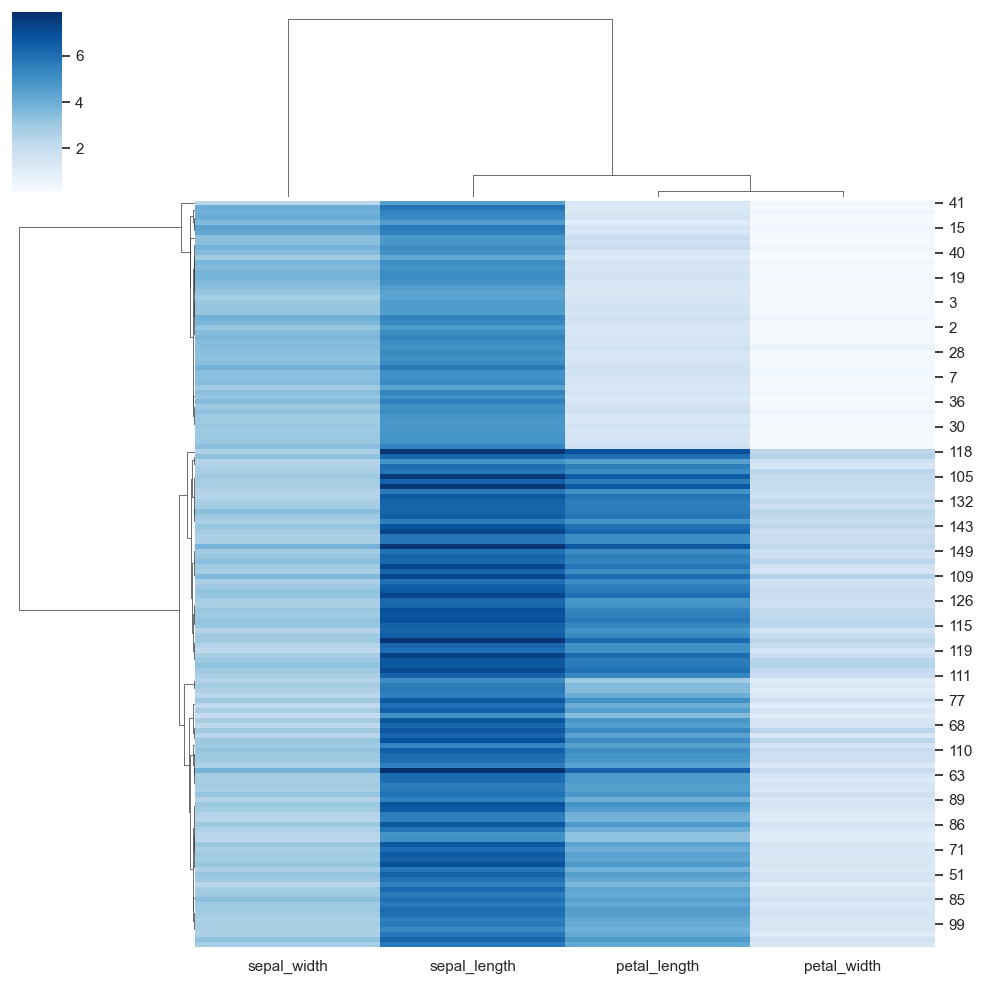

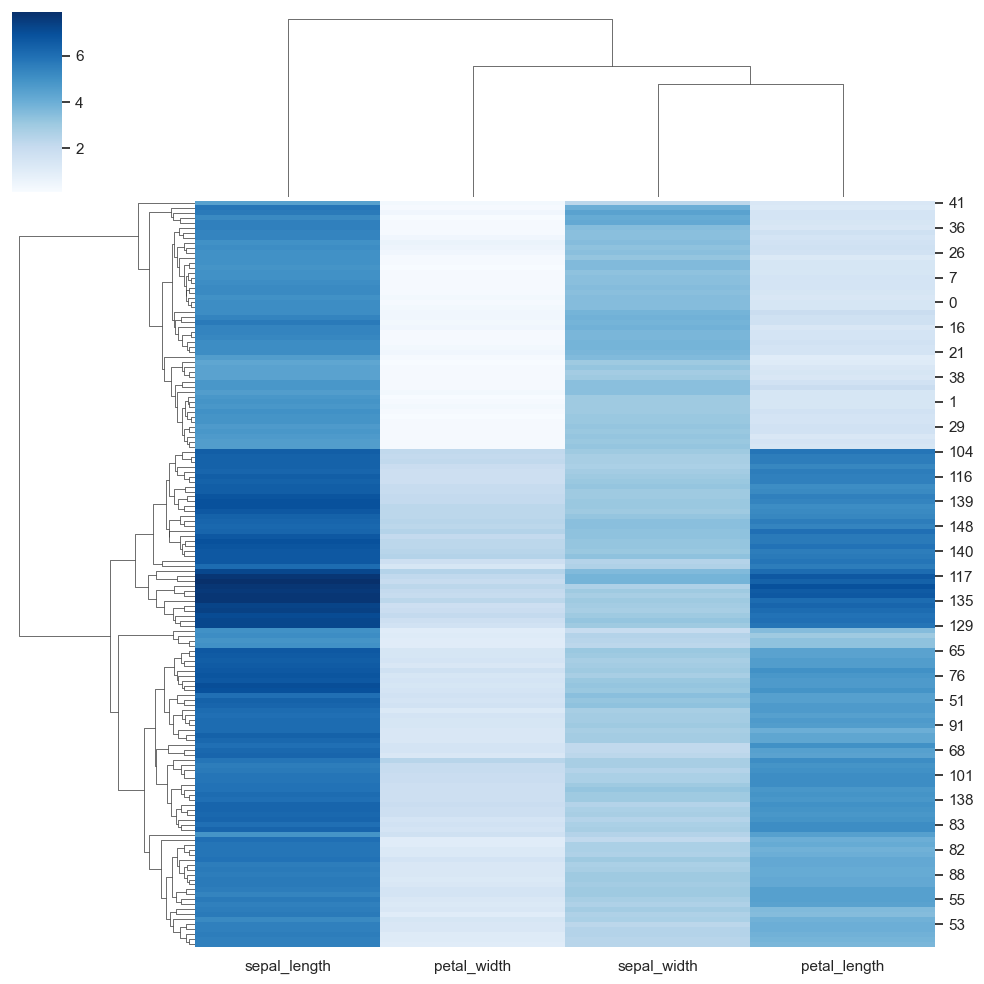

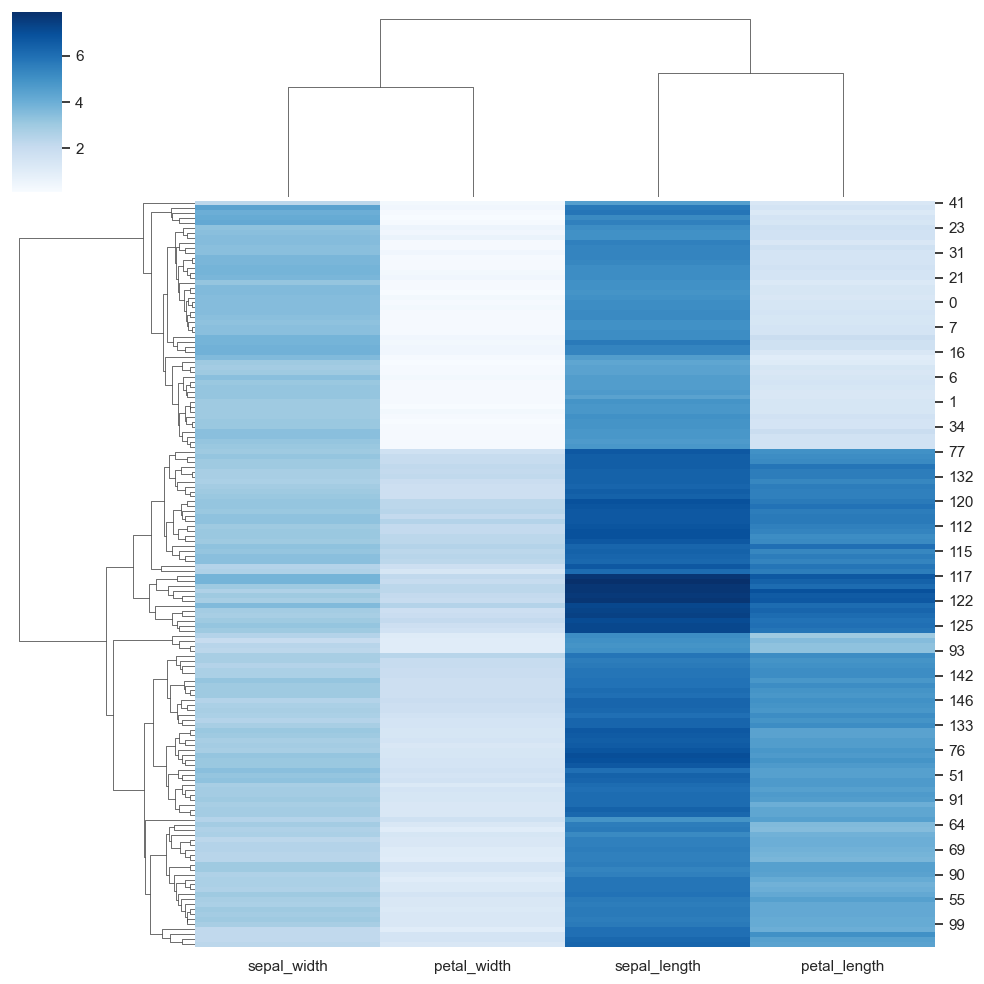

In [15]:
# Load the Iris dataset from seaborn
df_iris = sns.load_dataset('iris')

# Extract the features (columns) for clustering
sub_df_iris = df_iris.drop('species', axis=1)

# Plot the clustermap with Standardize every column in the figure
    # standard_scale : Either 0 (rows) or 1 (columns)

#Some possible distance metrics: "euclidean", "cityblock", "minkowski", "correlation", "cosine", "hamming"

sns.clustermap(sub_df_iris, cmap="Blues", metric="correlation")

sns.clustermap(sub_df_iris, cmap="Blues", metric="euclidean")

sns.clustermap(sub_df_iris, cmap="Blues", metric="cityblock")

#### Use different clustering methods

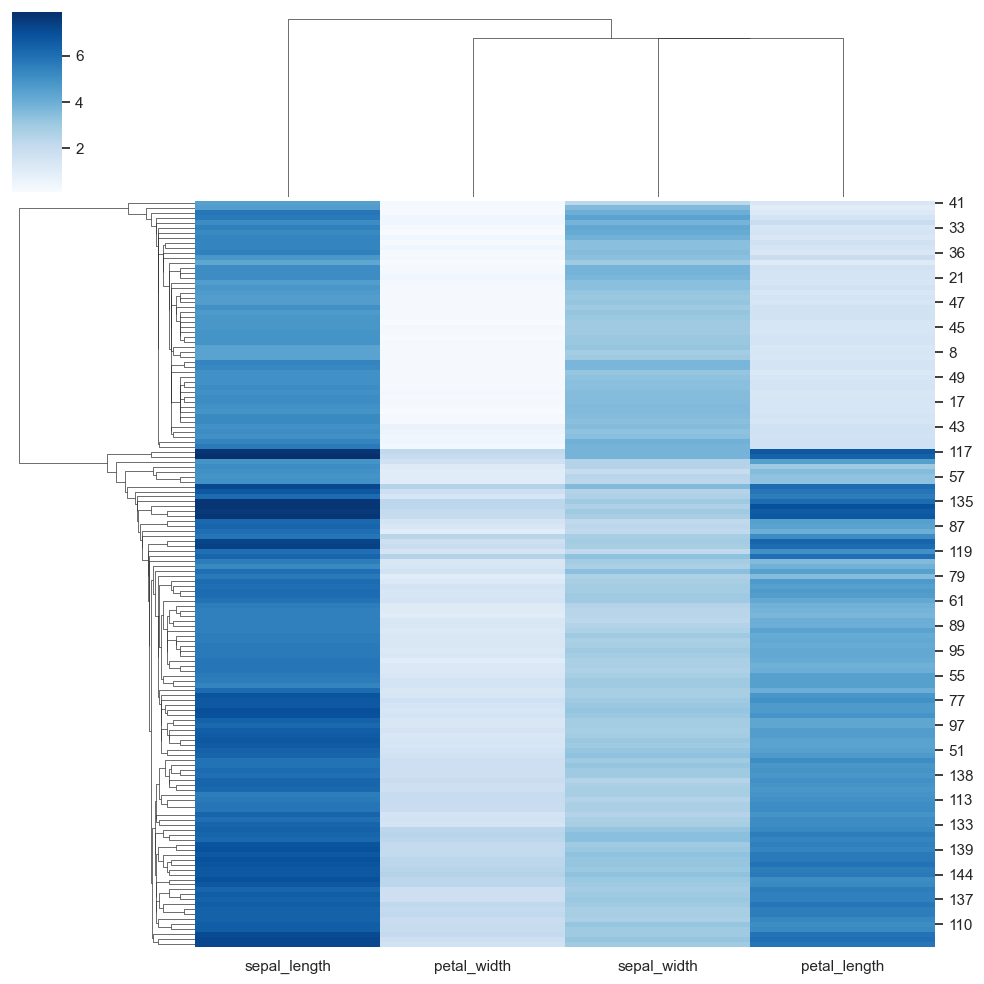

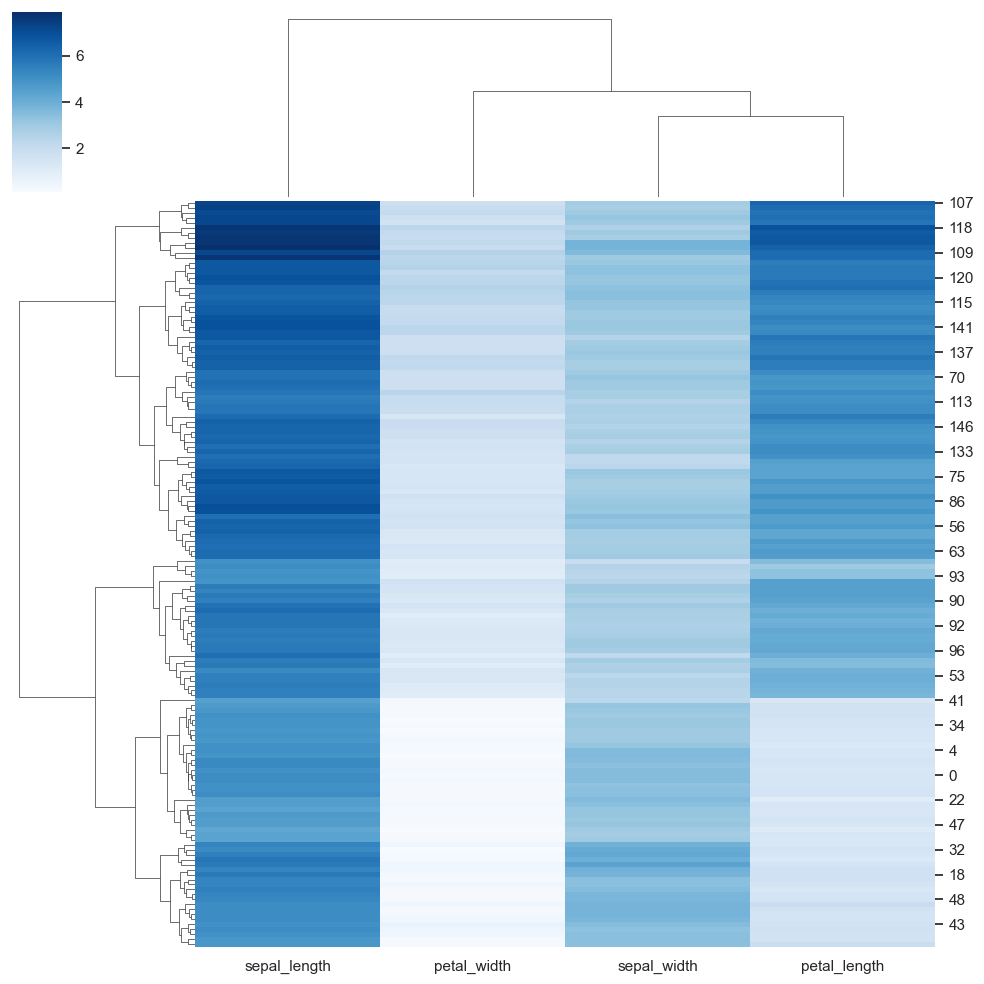

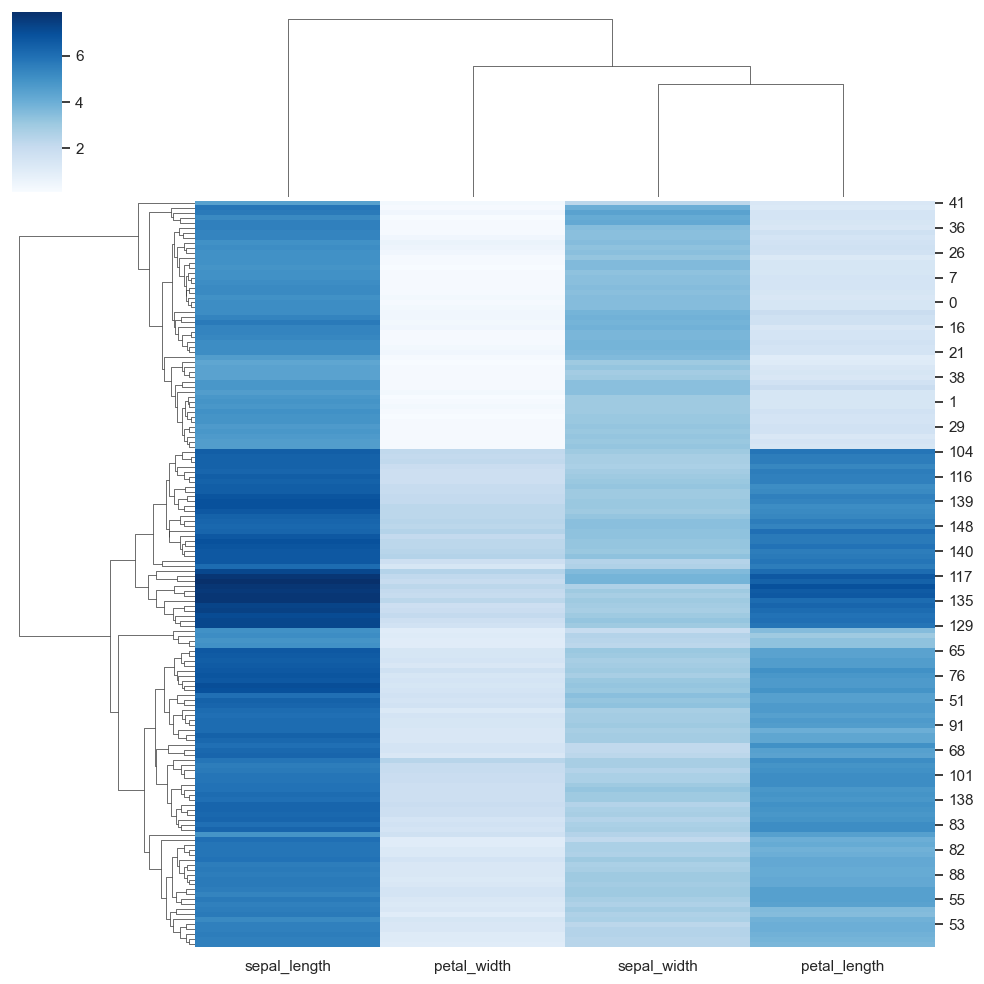

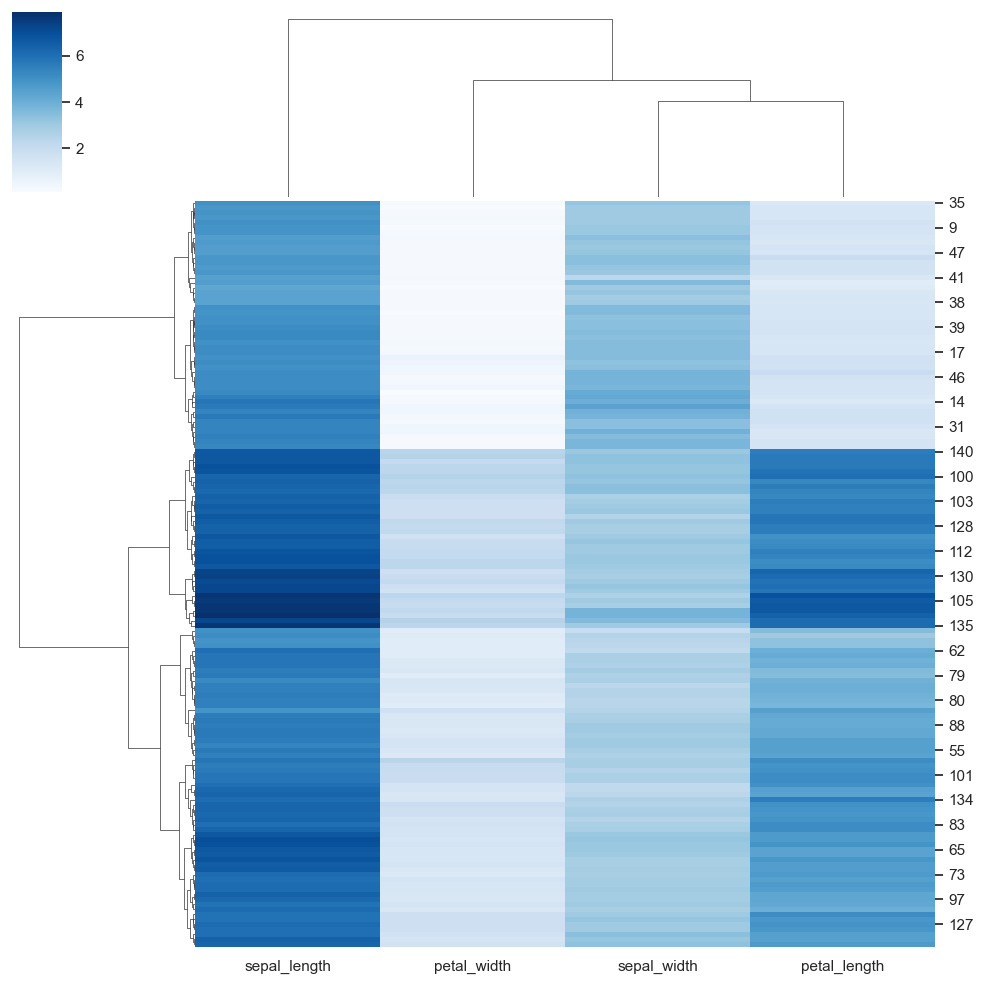

In [16]:
# Load the Iris dataset from seaborn
df_iris = sns.load_dataset('iris')

# Extract the features (columns) for clustering
sub_df_iris = df_iris.drop('species', axis=1)

# Plot the clustermap with Standardize every column in the figure
    # standard_scale : Either 0 (rows) or 1 (columns)

sns.clustermap(sub_df_iris, cmap="Blues", metric="euclidean", method="single")

sns.clustermap(sub_df_iris, cmap="Blues", metric="euclidean", method="complete")

sns.clustermap(sub_df_iris, cmap="Blues", metric="euclidean", method="average")

sns.clustermap(sub_df_iris, cmap="Blues", metric="euclidean", method="ward")

## HDBSCAN

In [17]:
conda install -c conda-forge hdbscan

Retrieving notices: ...working... done
Solving environment: / 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-arm64::notebook-shim==0.2.3=py310hca03da5_0
  - defaults/osx-arm64::anaconda-project==0.11.1=py310hca03da5_0
  - defaults/osx-arm64::ipykernel==6.28.0=py310hca03da5_0
  - defaults/osx-arm64::conda-build==3.28.3=py310hca03da5_0
  - defaults/osx-arm64::anaconda-client==1.12.2=py310hca03da5_0
  - defaults/osx-arm64::conda-index==0.3.0=py310hca03da5_0
  - defaults/osx-arm64::qtpy==2.4.1=py310hca03da5_0
  - defaults/osx-arm64::jupyter_core==5.5.0=py310hca03da5_0
  - defaults/osx-arm64::nbconvert==7.10.0=py310hca03da5_0
  - defaults/osx-arm64::jupyterlab_server==2.25.1=py310hca03da5_0
  - defaults/osx-arm64::nbformat==5.9.2=py310hca03da5_0
  - defaults/osx-arm64::ipython==8.20.0=py310hca03da5_0
  - defaults/osx-arm64::notebook==7.0.6=py310hca03da5_0
  - defaults/osx-arm64::nbclient==0.8.

#### Plot the scatter for the first two features Sepal length and Sepal width

Text(0.5, 1.0, 'Iris Sepal Length vs. Width')

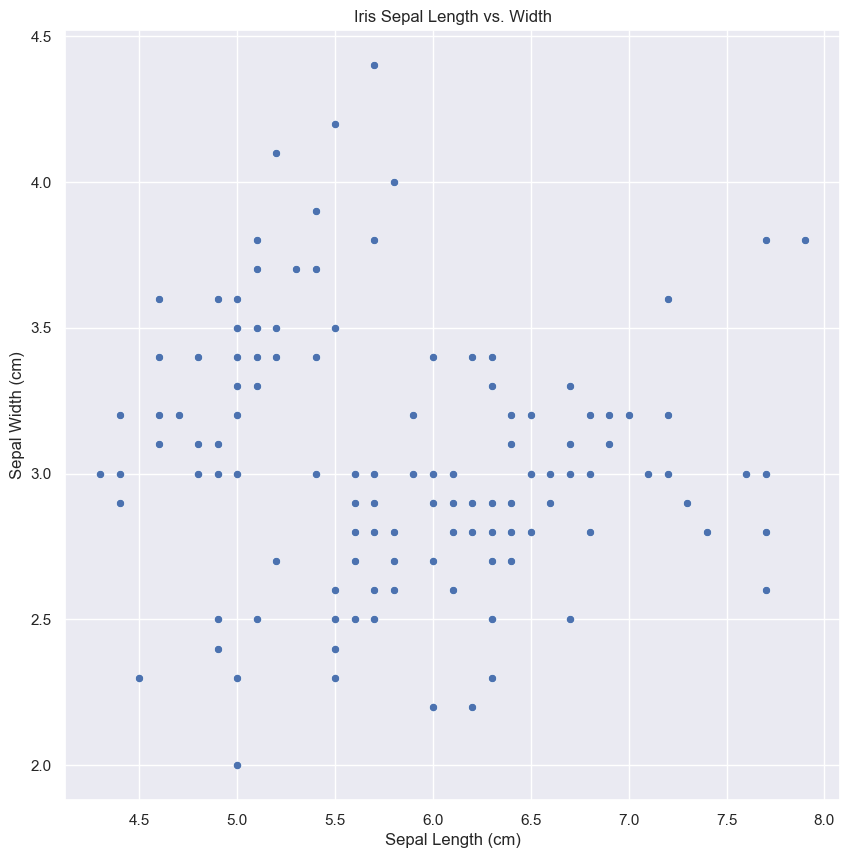

In [18]:
# Set the style for better visual aesthetics
sns.set(style="darkgrid")

# Create a scatter plot using Seaborn
sns.scatterplot(x=array_iris[:, 0], y=array_iris[:, 1])

# Set the labels and title
plt.xlabel("Sepal Length (cm)")
plt.ylabel("Sepal Width (cm)")
plt.title("Iris Sepal Length vs. Width")

#### Run HDBScan

In [19]:
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(array_iris)

ModuleNotFoundError: No module named 'hdbscan'

#### Plot the scatter plot for the first two features based on the clustering results

In [ ]:
plot_kwds = {'alpha': 0.5, 's': 80, 'linewidths': 0}
palette = sns.color_palette()
cluster_colors = [
    sns.desaturate(palette[col], sat) if col >= 0 else (0.5, 0.5)
    for col, sat in zip(clusterer.labels_, clusterer.probabilities_)
]

plt.scatter(array_iris[:, 0], array_iris[:, 1], c=cluster_colors, **plot_kwds)

#### Plot the scatter for the first two features Petal length and Petal width

In [ ]:
# Set the style for better visual aesthetics
sns.set(style="darkgrid")

# Create a scatter plot using Seaborn
sns.scatterplot(x=array_iris[:, 2], y=array_iris[:, 3])

# Set the labels and title
plt.xlabel("Petal Length (cm)")
plt.ylabel("Petal Width (cm)")
plt.title("Iris Petal Length vs. Width")

In [ ]:
# Plot the scatter plot for two features petal_length, and petal_width based on the clustering results
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat) 
                  if col >= 0 else (0.5, 0.5) for col, sat in 
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(array_iris[:,2], array_iris[:,3], c=cluster_colors, **plot_kwds)